# Militares com cargos comissionados

Neste notebook, nós vamos estimar a quantidade de militares ocupando cargos/funções comissionadas (i.e. de confiança) de nível alto (e.g. ministros de estado, secretários, diretores e coordenadores-gerais) no poder executivo federal, mês a mês, de 2013 a 2021. A análise é feita por ministério. 

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as pl
import numpy as np

import utils as xu

## Funções

Estas são funções que utilizamos durante a análise e processamento de dados:

In [2]:
def load_servidores_confianca(filename, usecols=None):
    """
    Carrega CSV de `filename` apenas colunas listadas em `usecols` 
    e linhas que tem função ou vínculo de natureza especial. 
    """
    df = pd.read_csv(filename, usecols=usecols, low_memory=False)
    df = df.loc[(df['sigla_funcao'] != '-1') | (df['situacao_vinculo'] == 'NATUREZA ESPECIAL')]
    return df

In [3]:
def add_date_inplace(df):
    """
    Build a date column from `df` columns 'ano' and 'mes' and append it 
    to the DataFrame `df`. The day is always 1.
    """
    df['data'] = pd.to_datetime(pd.DataFrame({'year': df['ano'], 'month': df['mes'], 'day': [1]*len(df)}))

In [4]:
def filter_funcao(df, funcao):
    """
    Select servidores from `df` (DataFrame) that belong to 
    `funcao` (str or list of str), which can be: 'NATUREZA ESPECIAL' 
    (selected from column 'situacao_vinculo'); 'MINISTRO DE ESTADO'
    (selected from column 'desc_cargo'); or selected from column 
    'sigla_funcao'.
    """
    if funcao == 'NATUREZA ESPECIAL':
        sel = df.loc[df['situacao_vinculo'] == 'NATUREZA ESPECIAL']
    elif funcao == 'MINISTRO DE ESTADO':
        sel = df.loc[df['desc_cargo'] == 'MINISTRO DE ESTADO']
    else:
        if type(funcao) == str:
            funcao = [funcao]
        sel = df.loc[df['sigla_funcao'].isin(funcao)]

    return sel

In [5]:
def filter_orgao(df, orgao, negate=False):
    """
    Select servidores from `df` (DataFrame) that belong to 
    `funcao` (str or list of str), which can be: 'NATUREZA ESPECIAL' 
    (selected from column 'situacao_vinculo'); 'MINISTRO DE ESTADO'
    (selected from column 'desc_cargo'); or selected from column 
    'sigla_funcao'.
    """
    
    if type(orgao) == str:
        orgao = [orgao]
    
    if negate:
        sel = df.loc[~(df['orgsup_exercicio'].isin(orgao) | df['org_exercicio'].isin(orgao))]
    else:
        sel = df.loc[  df['orgsup_exercicio'].isin(orgao) | df['org_exercicio'].isin(orgao)]

    return sel

In [6]:
def check_for_duplicated_servidores(df, subset):
    """
    Retorna a contagem de entradas duplicatas em `df`, dado um 
    conjunto `subset` de colunas.
    """
    n_duplicated = df.duplicated(subset=subset).sum()
    print('Found', n_duplicated, '(', n_duplicated/len(df)*100,'%) de entradas duplicatas.')

In [7]:
def set_empty_string_to_none(df, col):
    """
    Set all empty strings (length=0) in columns `col` of 
    DataFrame `df` to None, inplace.
    """
    df.loc[~df[col].isnull() & df[col].str.match('^$'), col] = None

In [8]:
def is_funcao(df, funcao):
    """
    Return a boolean series that tells if each row in `df` corresponds 
    to the specified `funcao`.
    """
    if funcao == 'NATUREZA ESPECIAL':
        return df['situacao_vinculo'] == 'NATUREZA ESPECIAL'
    
    elif funcao == 'MINISTRO DE ESTADO':
        return df['desc_cargo'] == 'MINISTRO DE ESTADO'
    
    else:
        if type(funcao) == str:
            funcao = [funcao]
        return df['sigla_funcao'].isin(funcao)

def is_nivel_alto(df, nivel_threshold, greater_is_good=True):
    """
    Return a boolean series that tells if each row in `df` 
    has a 'nivel de função' higher or lower than `nivel_threshold`.
    """
    if greater_is_good:
        return df['nivel_funcao'].str.slice(-1).astype(float) >= nivel_threshold
    else:
        return df['nivel_funcao'].str.slice(-1).astype(float) <= nivel_threshold

def sel_cargos_altos(df, include_nes=True):
    """
    Selects rows from `df` that corresponds to cargos altos.
    """
    ne = is_funcao(df, 'NATUREZA ESPECIAL')
    
    das_fpe = is_funcao(df, ['DAS', 'FPE']) & is_nivel_alto(df, 3.5)

    cge = is_funcao(df, 'CGE') & is_nivel_alto(df, 3.5, greater_is_good=False)
    
    nes = is_funcao(df, 'NES')
    
    #cce_fce = is_funcao(df, ['CCE', 'FCE']) ...
    
    if include_nes:
        return df.loc[ne | das_fpe | cge | nes]
    else:
        return df.loc[ne | das_fpe | cge]

In [9]:
#all_confianca.loc[is_funcao(all_confianca, ['CCE', 'FCE'])]

In [10]:
def count_servidores_by_date(df, funcao=None, orgao=None, negate_orgao=False):
    """
    Given a dataframe `df` with monthly records of servidores and their cargos,
    return the number of servidores with a given `funcao` (None, str or list of str),
    in exercício in a given `orgao` (None or str) in each date.
    """
    # Seleciona as funções desejadas:
    if funcao != None:
        sel = filter_funcao(df, funcao)
    else:
        sel = df
        
    # Seleciona um certo órgão:
    if orgao != None:
        sel = filter_orgao(sel, orgao, negate_orgao)
    
    # Conta o número de servidores por mês:
    counts = sel['data'].value_counts().sort_index()
    
    return counts

def build_militares_fraction_df(min_date, max_date, counts, counts_militares, counts_ativos, counts_inativos, orgao):
    """
    Build a dataframe covering months from `min_date` to `max_date` -1 with `counts` placed 
    in column 'n_total', `counts_militares` placed in 'n_militares' column, compute the 
    fraction and militares and create the column 'orgao' with `orgao` in it.
    """
    # Create DataFrame with all dates:
    df = pd.DataFrame()
    df['data'] = pd.Series(pd.date_range(min_date, max_date, freq='M')).apply(lambda dt: dt.replace(day=1))

    # Rename counts columns:
    counts.name           = 'n_total'
    counts_militares.name = 'n_militares'
    counts_ativos.name    = 'n_militares_ativos'
    counts_inativos.name  = 'n_militares_inativos'
    
    # Join counts to Dataframe:
    df = df.join(counts, on='data', how='outer').join(counts_militares, on='data', how='outer')
    df = df.join(counts_ativos, on='data', how='outer').join(counts_inativos, on='data', how='outer')
    df.fillna(0, inplace=True)

    # Compute fraction of militares:
    df['frac_militares'] = df['n_militares'] / df['n_total']

    # Compute fraction of ativos and inativos:
    df['frac_ativos']   = df['n_militares_ativos']   / df['n_militares']
    df['frac_inativos'] = df['n_militares_inativos'] / df['n_militares']
    
    # Add 'orgao' column:
    df['orgao'] = orgao
    
    return df

def microdados_to_counts_by_date_orgao(df_total, df_militares, orgao_list):
    """
    Given a DataFrame `df_total` with all servidores records and another 
    `df_militares` with the records for militares, select those in `orgao_list`
    and count them by orgão and date.
    """
    
    # Take slices of militares (ativos and inativos):
    df_ativos   = df_militares.loc[df_militares['base'] == 'militares']
    df_inativos = df_militares.loc[df_militares['base'] == 'civis']
    
    # Count servidores by date and orgao:
    counts_cargos_altos_by_orgao           = [count_servidores_by_date(df_total,     orgao=org) for org in orgao_list]
    counts_cargos_altos_militares_by_orgao = [count_servidores_by_date(df_militares, orgao=org) for org in orgao_list]
    counts_cargos_altos_ativos_by_orgao    = [count_servidores_by_date(df_ativos,    orgao=org) for org in orgao_list]
    counts_cargos_altos_inativos_by_orgao  = [count_servidores_by_date(df_inativos,  orgao=org) for org in orgao_list]
    
    # Specify date range:
    max_date = df_total['data'].max()
    max_date = (max_date + pd.Timedelta(days=36))
    max_date = max_date - pd.DateOffset(days = max_date.day - 1)
    min_date = df_total['data'].min()

    df = pd.concat([build_militares_fraction_df(min_date, max_date, c, m, a, i, orgao) for c, m, a, i, orgao in zip(counts_cargos_altos_by_orgao, 
                                                                                                                    counts_cargos_altos_militares_by_orgao,
                                                                                                                    counts_cargos_altos_ativos_by_orgao,
                                                                                                                    counts_cargos_altos_inativos_by_orgao,
                                                                                                                    orgao_list)], ignore_index=True)
    
    return df

## Carregando dados

Aqui nós carregamos os dados os dados necessários à análise. 

In [11]:
# Colunas de interesse:
cadastro_columns = ['mes', 'ano', 'id_servidor', 'nome', 'cpf', 'desc_cargo', 'classe_cargo', 
                    'padrao_cargo', 'nivel_cargo', 'sigla_funcao', 'nivel_funcao', 'funcao', 
                    'atividade', 'uorg_lotacao', 'org_lotacao', 'orgsup_lotacao', 'uorg_exercicio', 
                    'org_exercicio', 'orgsup_exercicio', 'tipo_vinculo', 'situacao_vinculo', 'regime_juridico',
                    'jornada_de_trabalho', 'ingresso_cargo_funcao', 'ingresso_orgao']

In [12]:
# Vamos colocar os servidores de ministérios extintos na conta dos ministérios que assumiram suas funções:
fusao_ministerio = xu.translate_dict({'Ministério da Cultura': 'Ministério do Turismo',
                    'Ministério da Indústria, Comércio Exterior e ': 'Ministério da Economia',
                    'Ministério do Planejamento, Desenvolvimento e': 'Ministério da Economia',
                    'Ministério do Trabalho e Emprego': 'Ministério da Economia',
                    'Ministério da Previdência Social': 'Ministério da Economia',
                    'Ministério do Desenvolvimento Social': 'Ministério da Cidadania',
                    'Ministério do Desenvolvimento Agrário': 'Ministério da Cidadania',
                    'Ministério do Esporte': 'Ministério da Cidadania',
                    'Ministério das Cidades': 'Ministério do Desenvolvimento Regional',
                    'MINISTERIO DAS COMUNICACOES': 'Ministério da Ciência, Tecnologia, Inovações ',
                    'Ministério das Comunicações': 'Ministério da Ciência, Tecnologia, Inovações ',
                    'Ministério da Pesca e Aquicultura': 'Ministério da Agricultura, Pecuária e Abastec'})

In [13]:
# Colunas efetivamente utilizadas neste notebook:
used_cols = ['sigla_funcao', 'situacao_vinculo', 'mes', 'ano', 'desc_cargo', 'orgsup_exercicio', 'org_exercicio', 'nivel_funcao', 'funcao', 'nome', 'cpf']

### Carregando cadastro de civis

Os dados sobre civis foram extraídos do banco de dados do Gabinete Compartilhado (que, por sua vez, obteve os dados do 
[Portal da Transparência](http://portaltransparencia.gov.br/download-de-dados/servidores)). Esses dados também estão disponíveis para SQL no projeto [Base dos dados +](https://basedosdados.github.io/mais/), embora possam estar desatualizados.

Os dados filtrados encontram-se disponíveis neste projeto.
Por alguns desses arquivos serem grandes, optamos por colocá-los no Google Storage. Favor baixá-los do endereço:
<https://storage.googleapis.com/gab-compartilhado-publico/militares-no-governo/servidores_de_confianca_civis_ateh_2021-01.csv> e <https://storage.googleapis.com/gab-compartilhado-publico/militares-no-governo/servidores_de_confianca_civis_2021-02_2021-12.csv>

#### Queries de SQL

Aqui apresentamos as queries em SQL que foram utilizadas para baixar os dados. Na prática, os dados já foram baixados e, possivelmente, via download pelo Console do BigQuery, que é mais rápido do que pelo código abaixo. As queries, portanto, servem de registro histórico.

In [14]:
# Construção da query para carregar dados de civis:
# (para dados até 01/2021)
sql_columns = ', '.join(cadastro_columns)
sql_conditions = "WHERE sigla_funcao != '-1' OR situacao_vinculo = 'NATUREZA ESPECIAL'"
query_1 = "SELECT " + sql_columns + " FROM `gabinete-compartilhado.executivo_federal_servidores.cadastro_civis` " + sql_conditions
print(query_1)

SELECT mes, ano, id_servidor, nome, cpf, desc_cargo, classe_cargo, padrao_cargo, nivel_cargo, sigla_funcao, nivel_funcao, funcao, atividade, uorg_lotacao, org_lotacao, orgsup_lotacao, uorg_exercicio, org_exercicio, orgsup_exercicio, tipo_vinculo, situacao_vinculo, regime_juridico, jornada_de_trabalho, ingresso_cargo_funcao, ingresso_orgao FROM `gabinete-compartilhado.executivo_federal_servidores.cadastro_civis` WHERE sigla_funcao != '-1' OR situacao_vinculo = 'NATUREZA ESPECIAL'


In [15]:
query_2 = """
SELECT 
mes, ano, id_servidor, nome, cpf, desc_cargo, classe_cargo, padrao_cargo, nivel_cargo, 
sigla_funcao, nivel_funcao, funcao, atividade, uorg_lotacao, org_lotacao, orgsup_lotacao, 
uorg_exercicio, org_exercicio, orgsup_exercicio, tipo_vinculo, situacao_vinculo, regime_juridico, 
jornada_de_trabalho, ingresso_cargo_funcao, ingresso_orgao 
FROM `gabinete-compartilhado.executivo_federal_servidores.cadastro_civis_completo` 
WHERE (sigla_funcao != '-1' OR situacao_vinculo = 'NATUREZA ESPECIAL')
AND data > '2021-01-01'
ORDER BY data
"""

#### Carregando os dados

In [16]:
def load_civis_data():
    """
    Essa função carrega os dados sobre civis de dois arquivos diferentes e depois os concatena.
    Fizemos isso dentro de uma função para eliminar da memória as tabelas não concatenadas.
    """
    # Carregando os dados sobre civis (até 01/2021):
    #df_confianca_civis_1 = xu.load_data_from_local_or_bigquery(query_1, 'dados/servidores_de_confianca_civis_ateh_2021-01.csv')
    df_confianca_civis_1 = pd.read_csv('dados/servidores_de_confianca_civis_ateh_2021-01.csv', usecols=used_cols, low_memory=False)
    # Carregando os dados sobre civis (a partir de 02/2021):
    #df_confianca_civis_2 = xu.load_data_from_local_or_bigquery(query_2, 'dados/servidores_de_confianca_civis_2021-02_2021-12.csv')
    df_confianca_civis_2 = pd.read_csv('dados/servidores_de_confianca_civis_2021-02_2021-12.csv', usecols=used_cols, low_memory=False)
    df_confianca_civis = pd.concat([df_confianca_civis_1, df_confianca_civis_2], ignore_index=True)
    
    return df_confianca_civis

# Carrega os dados:
df_confianca_civis = load_civis_data()

# Limpando os dados:
df_confianca_civis = df_confianca_civis.loc[~df_confianca_civis['situacao_vinculo'].isin(['APOSENTADO', 'APOSENTADO TCU733/94'])]
add_date_inplace(df_confianca_civis)
df_confianca_civis['base'] = 'civis'
set_empty_string_to_none(df_confianca_civis, 'nivel_funcao')
df_confianca_civis['orgsup_exercicio'] = df_confianca_civis['orgsup_exercicio'].map(fusao_ministerio)
# Pessoas do 'Poder Executivo Federal' são do COAF, que atualmente está vinculado ao Banco Central.
df_confianca_civis['orgsup_exercicio'] = df_confianca_civis['orgsup_exercicio'].map(xu.translate_dict({'Banco Central do Brasil': 'Ministério da Economia', 'Poder Executivo Federal': 'Ministério da Economia'}))
df_confianca_civis['org_exercicio']    = df_confianca_civis['org_exercicio'].map(fusao_ministerio)

### Carregando cadastro de militares da ativa

Os dados brutos sobre militares da ativa estavam salvos em arquivos locais (também obtidos do Portal da Transparência). Eles foram filtrados e salvos em um novo arquivo.

Por alguns desses arquivos serem grandes, optamos por colocá-los no Google Storage. Favor baixá-los do endereço:
<https://storage.googleapis.com/gab-compartilhado-publico/militares-no-governo/servidores_de_confianca_militares_ateh_2021-01.csv>

In [17]:
# Carrega funções/cargos de militares (dados que estavam armazenados localmente):

#cadastro_militares_files = sorted(glob('../dados/servidores-executivo-federal/limpos/militares/*_CadastroMilitares_cleaned.csv'))
#df_confianca_militares = pd.concat([load_servidores_confianca(f, cadastro_columns) for f in cadastro_militares_files], ignore_index=True)
#df_confianca_militares.to_csv('dados/servidores_de_confianca_militares_ateh_2021-01.csv', index=False)

PS: Os dados posteriores a 01/2021 (ao menos os capturados em abril de 2022) não possuem informações sobre vínculo via funções p/ militares. Esses militares da ativa com funções precisam ser identificados entre os civis.

In [18]:
# Carregando dados de militares:
df_confianca_militares = pd.read_csv('dados/servidores_de_confianca_militares_ateh_2021-01.csv', usecols=used_cols, low_memory=False)

# Limpando a base de militares:
add_date_inplace(df_confianca_militares)
df_confianca_militares['nivel_funcao'] = df_confianca_militares['nivel_funcao'].fillna(-666).astype(int).astype(str).str.zfill(4).str.replace('00-1', '-1').str.replace('-666', '')
df_confianca_militares['base'] = 'militares'
set_empty_string_to_none(df_confianca_militares, 'nivel_funcao')
df_confianca_militares['orgsup_exercicio'] = df_confianca_militares['orgsup_exercicio'].map(fusao_ministerio)
# Pessoas do 'Poder Executivo Federal' são do COAF, que atualmente está vinculado ao Banco Central.
df_confianca_militares['orgsup_exercicio'] = df_confianca_militares['orgsup_exercicio'].map(xu.translate_dict({'Banco Central do Brasil': 'Ministério da Economia', 'Poder Executivo Federal': 'Ministério da Economia'}))
df_confianca_militares['org_exercicio']    = df_confianca_militares['org_exercicio'].map(fusao_ministerio)

### Testando os dados

In [19]:
# Testes
uniqueness_cols =  ['ano', 'mes', 'nome', 'cpf', 'desc_cargo', 'sigla_funcao']
print(xu.Bold('Base de militares'))
check_for_duplicated_servidores(df_confianca_militares, uniqueness_cols)
print(xu.Bold('Base de civis'))
check_for_duplicated_servidores(df_confianca_civis, uniqueness_cols)

Base de militares
Found 0 ( 0.0 %) de entradas duplicatas.
Base de civis
Found 467 ( 0.0043059698630056155 %) de entradas duplicatas.


### Carregando lista de militares inativos com remuneração

Favor baixar os dados da remuneração dos militares inativos aqui:
    
<https://storage.googleapis.com/gab-compartilhado-publico/militares-no-governo/militares_inativos_2019-01_2021-11.csv>

In [20]:
# Lista de militares inativos remunerados no período entre 2019-01 e 2021-11 (existe um buraco no mês de setembro de 2021):
# Na verdade essa lista inclui os a lista de militares ativos também, para identificá-los entre os civis.
df_inativos = pd.read_csv('dados/militares_inativos_2019-01_2021-11.csv')

**Nota:** 

A lista de militares inativos acima corresponde àqueles recebendo alguma remuneração entre os meses de jan/2019 e novembro/2021, com um buraco em setembro/2021. Isso, em princípio, poderia ser um problema para identificar militares que estavam inativos em anos anteriores mas vieram a falecer antes de jan/2019: eles não estariam listados entre os inativos.

Para contornar esse problema, nós estimamos a taxa mensal com que militares deixam a inatividade (provavelmente, por motivo de falecimento) a partir da diferença entre os militares listados a cada mês. Tal taxa é bastante estável no período analisado e fica perto de 0,22% ao mês. Verificamos que a aplicação de uma correção no número estimado de militares para anos anteriores não altera as conclusões que essa análise nos traz: continuamos a identificar uma ligeira queda na presença de militares no período Dilma, uma ligeira alta no período Temer, e uma gigantesca alta no governo Bolsonaro.

## Criando amostras de comparação

Vamos criar a amostra com todos os servidores (civis e militares) e outra com os militares inativos.

Para lidar com elementos duplicados:

* Entre ativos e inativos, vamos eliminar o inativo que duplicar o ativo;
* Entre militares e civis, vamos eliminar o militar que duplicar o civil;

In [21]:
# Todos os servidores com cargos/funções, sejam civis ou militares:
all_confianca = pd.concat([df_confianca_civis, df_confianca_militares], ignore_index=True)
all_confianca = all_confianca.sort_values('base').drop_duplicates(subset=used_cols, keep='first')

# Militares inativos com cargos/funções:
extra_columns = ['base', 'data', 'data_primeiro_registro_ativo', 'data_ultimo_registro_ativo', 'data_primeiro_registro_inativo', 'data_ultimo_registro_inativo']
df_confianca_inativos = df_confianca_civis.merge(df_inativos, left_on=['nome', 'cpf'], right_on=['nome', 'cpf'], how='inner')[used_cols + extra_columns]

# Todos os militares com cargos/funcoes, sejam ativos ou inativos:
df_confianca_ativos_inativos = pd.concat([df_confianca_militares, df_confianca_inativos], ignore_index=True)
df_confianca_ativos_inativos = df_confianca_ativos_inativos.sort_values('base').drop_duplicates(subset=used_cols, keep='last')

# Apenas os servidores civis com cargos/funções:
df_confianca_so_civis = df_confianca_civis.loc[~(df_confianca_civis['nome'] + df_confianca_civis['cpf']).isin(df_inativos['nome'] + df_inativos['cpf'])]

### Testando os dados

In [22]:
# Verificando a quantidade de dados duplicados
print(xu.Bold('Todos os servidores'))
check_for_duplicated_servidores(all_confianca, uniqueness_cols)
print(xu.Bold('Militares inativos'))
check_for_duplicated_servidores(df_confianca_inativos, uniqueness_cols)
print(xu.Bold('Todos os militares'))
check_for_duplicated_servidores(df_confianca_ativos_inativos, uniqueness_cols)

Todos os servidores
Found 59 ( 0.0005352780923922649 %) de entradas duplicatas.
Militares inativos
Found 0 ( 0.0 %) de entradas duplicatas.
Todos os militares
Found 0 ( 0.0 %) de entradas duplicatas.


In [23]:
n_dupli_militar_civil = all_confianca.duplicated(subset=used_cols).sum()
print('Existem', n_dupli_militar_civil, 'servidores identicamente listados tanto na base de militares quanto na de civis.')

Existem 0 servidores identicamente listados tanto na base de militares quanto na de civis.


In [24]:
n_dupli_ativo_inativo = df_confianca_ativos_inativos.duplicated(subset=used_cols).sum()
print('Existem', n_dupli_ativo_inativo, 'servidores identicamente listados tanto na base de ativos quanto de inativos.')

Existem 0 servidores identicamente listados tanto na base de ativos quanto de inativos.


## Contagem de militares em órgãos específicos

### Contagem de militares no IBAMA

In [46]:
ibama = 'Instituto Brasileiro do Meio Ambiente e Recur'
ibama_all       = sel_cargos_altos(all_confianca.loc[all_confianca['org_exercicio'] == ibama])
ibama_militares = sel_cargos_altos(df_confianca_ativos_inativos.loc[df_confianca_ativos_inativos['org_exercicio'] == ibama])

In [51]:
# Compute fraction of militares in orgaos:
df_frac = microdados_to_counts_by_date_orgao(ibama_all, ibama_militares, [ibama])
df_frac['data_text'] = df_frac['data'].dt.strftime('%m/%Y') 
#df_frac['frac_militares'] = df_frac['frac_militares'] * 100

In [52]:
#df_frac.to_csv('resultados/frac_militares_cargos_altos_ibama_por_mes_ateh_2020-09.csv', index=False)

### Contagem de militares na Saúde e Programa de imunizações

In [34]:
all_saude = filter_orgao(all_confianca, 'Ministério da Saúde')

In [35]:
militares_saude = filter_orgao(df_confianca_ativos_inativos, 'Ministério da Saúde')

## Seleção e contagem de cargos altos

Vamos fazer um recorte nos dados, selecionando apenas os cargos altos, ou seja, vamos selecionar apenas cargos de natureza especial e funções NES, DAS 4-6, FCPE 4-5 e CGE I-III.

**PS:**
* Não fazer esse tipo de recorte pode dificultar a análise, pois existem cargos/funções que são especificamente direcionados a militares. Além disso, alguns cargos/funções podem surgir ou desaparecer ao longo do tempo, incorporando ou desmembrando anteriores. Um exemplo disso foi o surgimento do FCPE. 
* Não vamos analisar os comandos das forças armadas.
* Em 15/abril/2021, foram criados os cargos CCE e FCE para substituir os DAS e FCPE. O processo de substituição é lento e não apareceu nas bases por enquanto.

### Recorte nos dados

In [26]:
# Cria lista de orgão de interesse:
orgsup_list = all_confianca.loc[all_confianca['orgsup_exercicio'] != 'Sem informação', 'orgsup_exercicio'].unique()
org_list    = all_confianca.loc[all_confianca['org_exercicio'].str.contains('minist[ée]rio', case=False), 'org_exercicio'].unique()
sel_org_sup = list((set(orgsup_list) | set(org_list)) - {'Comando da Aeronáutica', 'Comando da Marinha', 'Comando do Exército'})

#### Parênteses - Órgão "Poder Executivo Federal"

Em agosto de 2021, surgiu um órgão na base denominado "Poder Executivo Federal". Verificamos que essas pessoas fazem parte do COAF, mas não existem militares ocupando cargos altos nesse órgão.

In [26]:
# Seleção de servidores nesse órgão:
executivo = all_confianca.loc[all_confianca['orgsup_exercicio'] == 'Poder Executivo Federal']
executivo_hist = all_confianca.loc[(all_confianca['nome']+all_confianca['cpf']).isin(set(executivo['nome']+executivo['cpf']))].sort_values(['nome', 'cpf', 'ano', 'mes'])
executivo_militar = df_confianca_ativos_inativos.loc[df_confianca_ativos_inativos['orgsup_exercicio'] == 'Poder Executivo Federal']

In [27]:
executivo[['nome', 'cpf', 'data']].sort_values('data').drop_duplicates(subset=['nome', 'cpf'])

Empty DataFrame
Columns: [nome, cpf, data]
Index: []

In [46]:
# Exemplo em cargo alto:
executivo.loc[executivo['nivel_funcao'] == '1016'].sort_values('data')

mes   ano          nome             cpf      desc_cargo  \
10696212    8  2021  RICARDO LIAO  ***.366.961-**  Sem informação   
10834373    9  2021  RICARDO LIAO  ***.366.961-**  Sem informação   
9813379    10  2021  RICARDO LIAO  ***.366.961-**  Sem informação   
10155191   11  2021  RICARDO LIAO  ***.366.961-**  Sem informação   
10464844   12  2021  RICARDO LIAO  ***.366.961-**  Sem informação   

         sigla_funcao nivel_funcao            org_exercicio  \
10696212          DAS         1016  Poder Executivo Federal   
10834373          DAS         1016  Poder Executivo Federal   
9813379           DAS         1016  Poder Executivo Federal   
10155191          DAS         1016  Poder Executivo Federal   
10464844          DAS         1016  Poder Executivo Federal   

                 orgsup_exercicio      situacao_vinculo       data   base  
10696212  Poder Executivo Federal  NOMEADO CARGO COMIS. 2021-08-01  civis  
10834373  Poder Executivo Federal  NOMEADO CARGO COMIS. 2021-09-01  civis  
9813379   Poder Executivo Federal  NOMEADO CARGO COMIS. 2021-10-01  civis  
10155191  Poder Executivo Federal  NOMEADO CARGO COMIS. 2021-11-01  civis  
10464844  Poder Executivo Federal  NOMEADO CARGO COMIS. 2021-12-01  civis

In [42]:
# Cargos ocupados por servidores militares e civis:
executivo.groupby(['sigla_funcao', 'nivel_funcao', 'desc_cargo']).size()

sigla_funcao  nivel_funcao  desc_cargo    
DAS           1011          Sem informação    60
              1012          Sem informação    66
              1013          Sem informação    30
              1014          Sem informação    50
              1015          Sem informação    15
              1016          Sem informação     5
              1021          Sem informação     5
              1022          Sem informação     6
              1023          Sem informação    10
              1024          Sem informação     5
FGR           0001          Sem informação    10
dtype: int64

In [44]:
# Cargos ocupados por servidores militares:
executivo_militar.groupby(['sigla_funcao', 'nivel_funcao', 'desc_cargo']).size()

sigla_funcao  nivel_funcao  desc_cargo    
DAS           1012          Sem informação    10
dtype: int64

In [47]:
# Trajetória de um servidor até o órgão:
i = 110
executivo_hist.iloc[i:i+10]

mes   ano                    nome             cpf      desc_cargo  \
1739933    5  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
1759000    6  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
8625710    7  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
1707245    8  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
3523275    9  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
6583728   10  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
1745647   11  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
5682518   12  2019  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
2729118    1  2020  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   
4697561    2  2020  ALEANDRO DE LIMA FELIX  ***.674.971-**  Sem informação   

        sigla_funcao nivel_funcao                              org_exercicio  \
1739933          DAS         1011  Ministério da Justiça e Segurança Pública   
1759000          DAS         1011  Ministério da Justiça e Segurança Pública   
8625710          DAS         1011  Ministério da Justiça e Segurança Pública   
1707245          DAS         1011  Ministério da Justiça e Segurança Pública   
3523275          DAS         1011  Ministério da Justiça e Segurança Pública   
6583728          DAS         1011  Ministério da Justiça e Segurança Pública   
1745647          DAS         1011  Ministério da Justiça e Segurança Pública   
5682518          DAS         1011  Ministério da Justiça e Segurança Pública   
2729118          DAS         1011  Ministério da Justiça e Segurança Pública   
4697561          DAS         1011  Ministério da Justiça e Segurança Pública   

        orgsup_exercicio      situacao_vinculo       data   base  
1739933   Sem informação  NOMEADO CARGO COMIS. 2019-05-01  civis  
1759000   Sem informação  NOMEADO CARGO COMIS. 2019-06-01  civis  
8625710   Sem informação  NOMEADO CARGO COMIS. 2019-07-01  civis  
1707245   Sem informação  NOMEADO CARGO COMIS. 2019-08-01  civis  
3523275   Sem informação  NOMEADO CARGO COMIS. 2019-09-01  civis  
6583728   Sem informação  NOMEADO CARGO COMIS. 2019-10-01  civis  
1745647   Sem informação  NOMEADO CARGO COMIS. 2019-11-01  civis  
5682518   Sem informação  NOMEADO CARGO COMIS. 2019-12-01  civis  
2729118   Sem informação  NOMEADO CARGO COMIS. 2020-01-01  civis  
4697561   Sem informação  NOMEADO CARGO COMIS. 2020-02-01  civis

#### Seleção de cargos altos

In [27]:
# Nomes mais simples para os ministérios:
simplify_orgaos = {'Ministério da Agricultura, Pecuária e Abastec': 'Agricultura',
 'Presidência da República': 'Presidência',
 'Ministério das Relações Exteriores': 'Relações Exteriores',
 'Ministério da Educação': 'Educação',
 'Ministério da Cidadania': 'Cidadania',
 'Ministério da Saúde': 'Saúde',
 'Ministério de Minas e Energia': 'Minas e Energia',
 'Ministério da Ciência, Tecnologia, Inovações ': 'Ciência & Comunicações',
 'Ministério da Economia': 'Economia',
 'Ministério do Desenvolvimento Regional': 'Desenv. Regional',
 'Ministério da Mulher, Família e Direitos Huma': 'Direitos Humanos',
 'Ministério da Defesa': 'Defesa',
 'Ministério da Justiça e Segurança Pública': 'Justiça',
 'Ministério do Meio Ambiente': 'Meio Ambiente',
 'Ministério do Turismo': 'Turismo',
 'Ministério da Infraestrutura': 'Infraestrutura'}

In [28]:
# Seleciona cargos altos:
df_cargos_altos           = filter_orgao(sel_cargos_altos(all_confianca), sel_org_sup)
df_cargos_altos_militares = filter_orgao(sel_cargos_altos(df_confianca_ativos_inativos), sel_org_sup)

#### Pedidos de jornalistas

In [32]:
# Construindo lista de militares em órgãos específicos:
sel_orgaos = ['Presidência da República', 'Ministério de Minas e Energia', 'Ministério do Meio Ambiente']
df_militares_orgaos = filter_orgao(df_cargos_altos_militares.loc[(df_cargos_altos_militares['data'] == '2020-09-01')], sel_orgaos)
#df_militares_orgaos.to_csv('./resultados/nomes_militares_presidencia_energia_ambiente_2020-09.csv', index=False)

In [33]:
# Construindo lista de militares na saúde:
df_militares_saude = filter_orgao(df_cargos_altos_militares.loc[(df_cargos_altos_militares['data'] == '2020-09-01')], 'Ministério da Saúde')
#df_militares_saude.to_csv('./resultados/nomes_militares_na_saude_2020-09.csv', index=False)

# Lista de nomes que o repórter Bernardo Peixoto selecionou que não estão na lista:
militares_reporter_bernardo = ['ANTONIO ELCIO FRANCO FILHO', 'CLAUDIO ALMEIDA DA COSTA', 'JOE SACCENTI JUNIOR', 'MARCOS DE CARVALHO', 'RIDAUTO LUCIO FERNANDES', 'CEZAR WILKER TAVARES SCHWAB RODRIGUES']
# O primeiro é NES, deveria ter sido incluido. Os demais entraram pós setembro-2020.

### Agregando os dados (contando o número de servidores)

In [29]:
# Compute fraction of militares in orgaos:
df_frac = microdados_to_counts_by_date_orgao(df_cargos_altos, df_cargos_altos_militares, sel_org_sup)
df_frac['data_text'] = df_frac['data'].dt.strftime('%m/%Y') 
df_frac['frac_militares'] = df_frac['frac_militares'] * 100
df_frac['orgao'] = df_frac['orgao'].map(simplify_orgaos)

Abaixo nós exportamos a contagem de servidores para um arquivo CSV. Os mesmos dados estão disponíveis no link:

<https://docs.google.com/spreadsheets/d/1e7qfBBNXN3FA7LFq08ymaocMeeakYcSrdD62OTfhVIE>

In [31]:
# Export data to table (to send to Rafael):
#df_frac['frac_militares'] = df_frac['frac_militares'] / 100
#df_frac.to_csv('resultados/numero_servidores_total_e_militares_ativos_inativos_por_orgao_e_mes_ateh_2021-12.csv', index=False)
#df_frac['frac_militares'] = df_frac['frac_militares'] * 100

## Visualização dos resultados

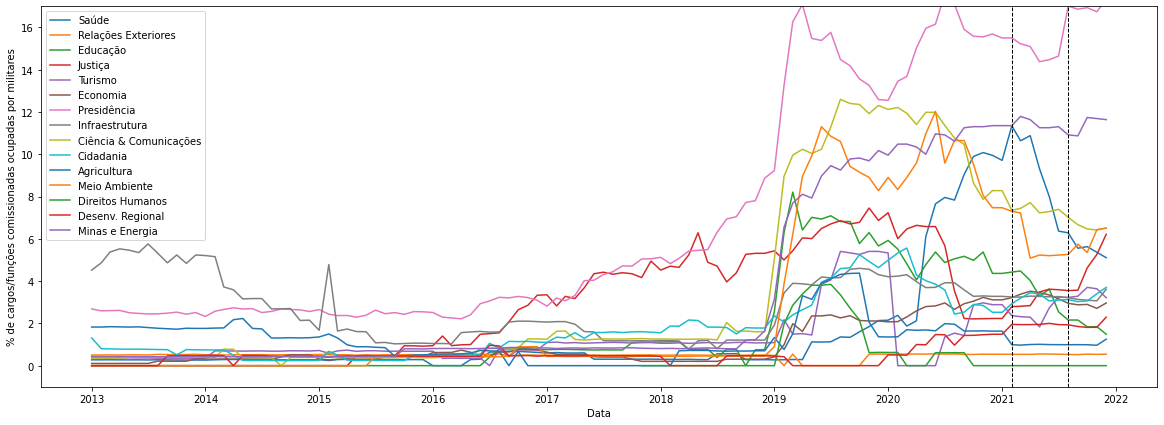

In [36]:
pl.figure(figsize=(20,7))
for orgao in set(sel_org_sup) - {'Ministério da Defesa', 'Poder Executivo Federal'}:
    sel = df_frac.loc[df_frac['orgao'] == simplify_orgaos[orgao]]
    pl.plot(sel['data'], sel['frac_militares'], label=simplify_orgaos[orgao])
pl.legend()
pl.xlabel('Data')
pl.ylabel('% de cargos/funções comissionadas ocupadas por militares')
pl.axvline(pd.to_datetime('2021-02-01'), color='k', linewidth=1, linestyle='--')
pl.axvline(pd.to_datetime('2021-08-01'), color='k', linewidth=1, linestyle='--')
pl.ylim([-1,17])
pl.show()

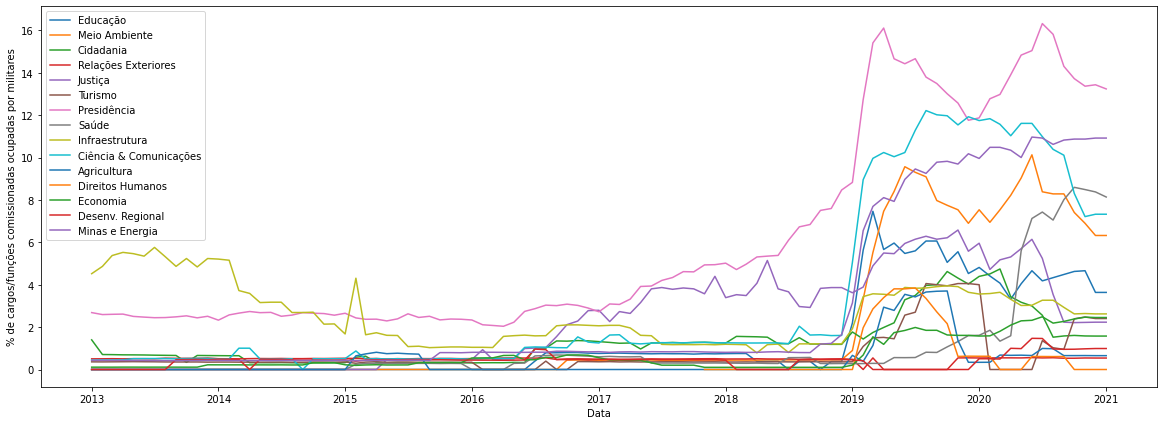

In [30]:
# Plot antigo (essa célula não foi atualizada depois dos dados serem atualizados):
pl.figure(figsize=(20,7))
for orgao in set(sel_org_sup) - {'Ministério da Defesa'}:
    sel = df_frac.loc[df_frac['orgao'] == simplify_orgaos[orgao]]
    pl.plot(sel['data'], sel['frac_militares'], label=simplify_orgaos[orgao])
pl.legend()
pl.xlabel('Data')
pl.ylabel('% de cargos/funções comissionadas ocupadas por militares')
pl.show()

### Preparação dos dados para o Flourish

O gráfico final, animado, foi feito com a plataforma [Flourish](https://flourish.studio/). Vamos colocar os dados no formato exigido por eles:

In [37]:
# É preciso pivotar os dados e colocar as datas nas colunas:
# Vamos ignorar o Ministério da Defesa:
data_columns     = list(df_frac['data_text'].drop_duplicates())
df_frac_pivoted  = df_frac.loc[df_frac['orgao'] != 'Defesa'].pivot(index='orgao', columns='data_text', values='frac_militares')[data_columns]

# Para a animação ficar melhor, sem ruídos, vamos aplicar uma média móvel aos resultados:
df_frac_smoothed = df_frac_pivoted.rolling(3, min_periods=1, center=False, axis=1).mean()

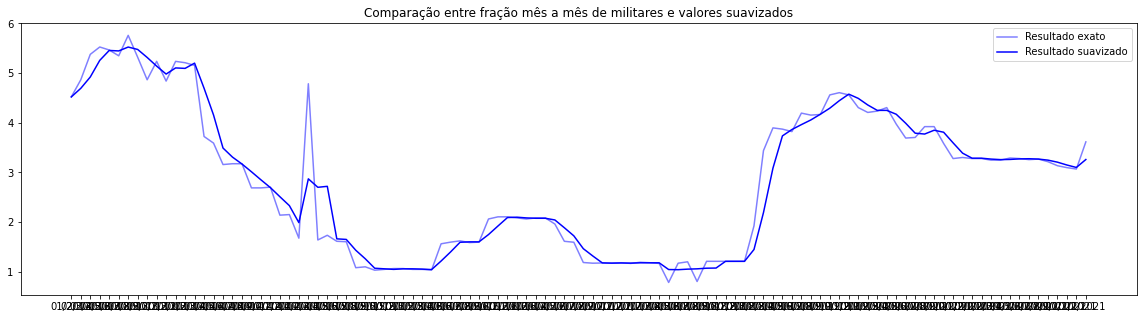

In [38]:
# Vamos verificar como ficam os dados suavizados:
orgao = 'Infraestrutura'
pl.figure(figsize=(20,5))
pl.plot(df_frac_pivoted.transpose()[orgao], color='b', alpha=0.5, label='Resultado exato')
pl.plot(df_frac_smoothed.transpose()[orgao], color='b', label='Resultado suavizado')
pl.legend()
pl.title('Comparação entre fração mês a mês de militares e valores suavizados')
pl.show()

In [39]:
# Vamos adicionar à tabela os links dos logos de cada ministério:
df_image_links = pd.read_csv('resultados/logo_para_grafico_do_flourish.csv')
df_image_links = df_image_links.set_index('orgao', drop=True)

df_to_flourish = df_frac_smoothed.join(df_image_links)[['logo'] + data_columns]

In [40]:
# Exportando os dados para carregar no Flourish:

#df_to_flourish.to_csv('resultados/frac_militares_por_orgao_e_mes_ateh_2021-12.csv')

## Análise anterior (counts de militares e civis por órgãos e data)

A análise desta seção foi auxiliar ao projeto e não foi utilizada na sua versão final. Por esse motivo, ela não foi documentada em detalhe.

In [40]:
def plot_compare_servidor_counts(df1, df2, funcao=None, orgao=None, negate_orgao=False):

    pl.plot(count_servidores_by_date(df1, funcao, orgao, negate_orgao), color='royalblue')
    pl.setp(pl.gca().get_yticklabels(), color="royalblue")

    
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))

    ax2 = pl.gca().twinx()
    ax2.plot(count_servidores_by_date(df2, funcao, orgao, negate_orgao), color='firebrick')
    ax2.tick_params(labelcolor='firebrick')
    ax2.tick_params

In [41]:
funcoes_interesse = ['DAS', 'NES', 'FPE', 'CGE', 'CA', 'CD', 'CCD', 'FAA', 'FCT', 'FG', 'FTS', 'FUC']

In [42]:
funcao_list = ['MINISTRO DE ESTADO', 'NATUREZA ESPECIAL'] + list(all_confianca['sigla_funcao'].value_counts().sort_values(ascending=False).index)

* RMP - Cargo em Confiança devida a Militares
* RMA - Exercício de Função - graduados do Ministério da Defesa
* ETG - Estágio
* CA  - Cargo Comissionado de Assessoria
* DAS - Direção e Assessoramento Superior
* GF  - Função Gratificada
* FG  - Função Gratificada - IFES
* NES - Cargo de Natureza Especial
* FGR - Função Gratificada LEI 8.216/91
* GT  - GRAT. TEMPORARIA ( MP 330/93 )
* FUC - FUNCAO COMISSIONADA DE COORD. CURSO
* FAA e FTS - Ligadas à Amazônia Azul Tecnologias de Defesa
* FBC - Função comissionada do Banco Central
* CD  - Cargo de direção - IFES
* FCT - Função comissionada técnica, aparentemente conferida apenas a servidores efetivos: <http://www.planalto.gov.br/ccivil_03/decreto/2003/D4941.htm>

In [63]:
def filter_orgao(df, orgao, negate=False):
    """
    Select servidores from `df` (DataFrame) that belong to 
    `funcao` (str or list of str), which can be: 'NATUREZA ESPECIAL' 
    (selected from column 'situacao_vinculo'); 'MINISTRO DE ESTADO'
    (selected from column 'desc_cargo'); or selected from column 
    'sigla_funcao'.
    """
    
    if type(orgao) == str:
        orgao = [orgao]
    
    if negate:
        sel = df.loc[~(df['orgsup_exercicio'].isin(orgao) | df['org_exercicio'].isin(orgao))]
    else:
        sel = df.loc[  df['orgsup_exercicio'].isin(orgao) | df['org_exercicio'].isin(orgao)]

    return sel

In [69]:
orgao = 'Ministério do Turismo'
s = filter_funcao(all_confianca, 'DAS')
s.loc[(s.org_exercicio == orgao) | (s.orgsup_exercicio == orgao)].data.value_counts().sort_index()

2013-01-01    1144
2013-02-01    1137
2013-03-01    1137
2013-04-01    1124
2013-05-01    1139
              ... 
2020-05-01      67
2020-06-01      81
2020-07-01     234
2020-08-01     422
2020-09-01     468
Name: data, Length: 93, dtype: int64

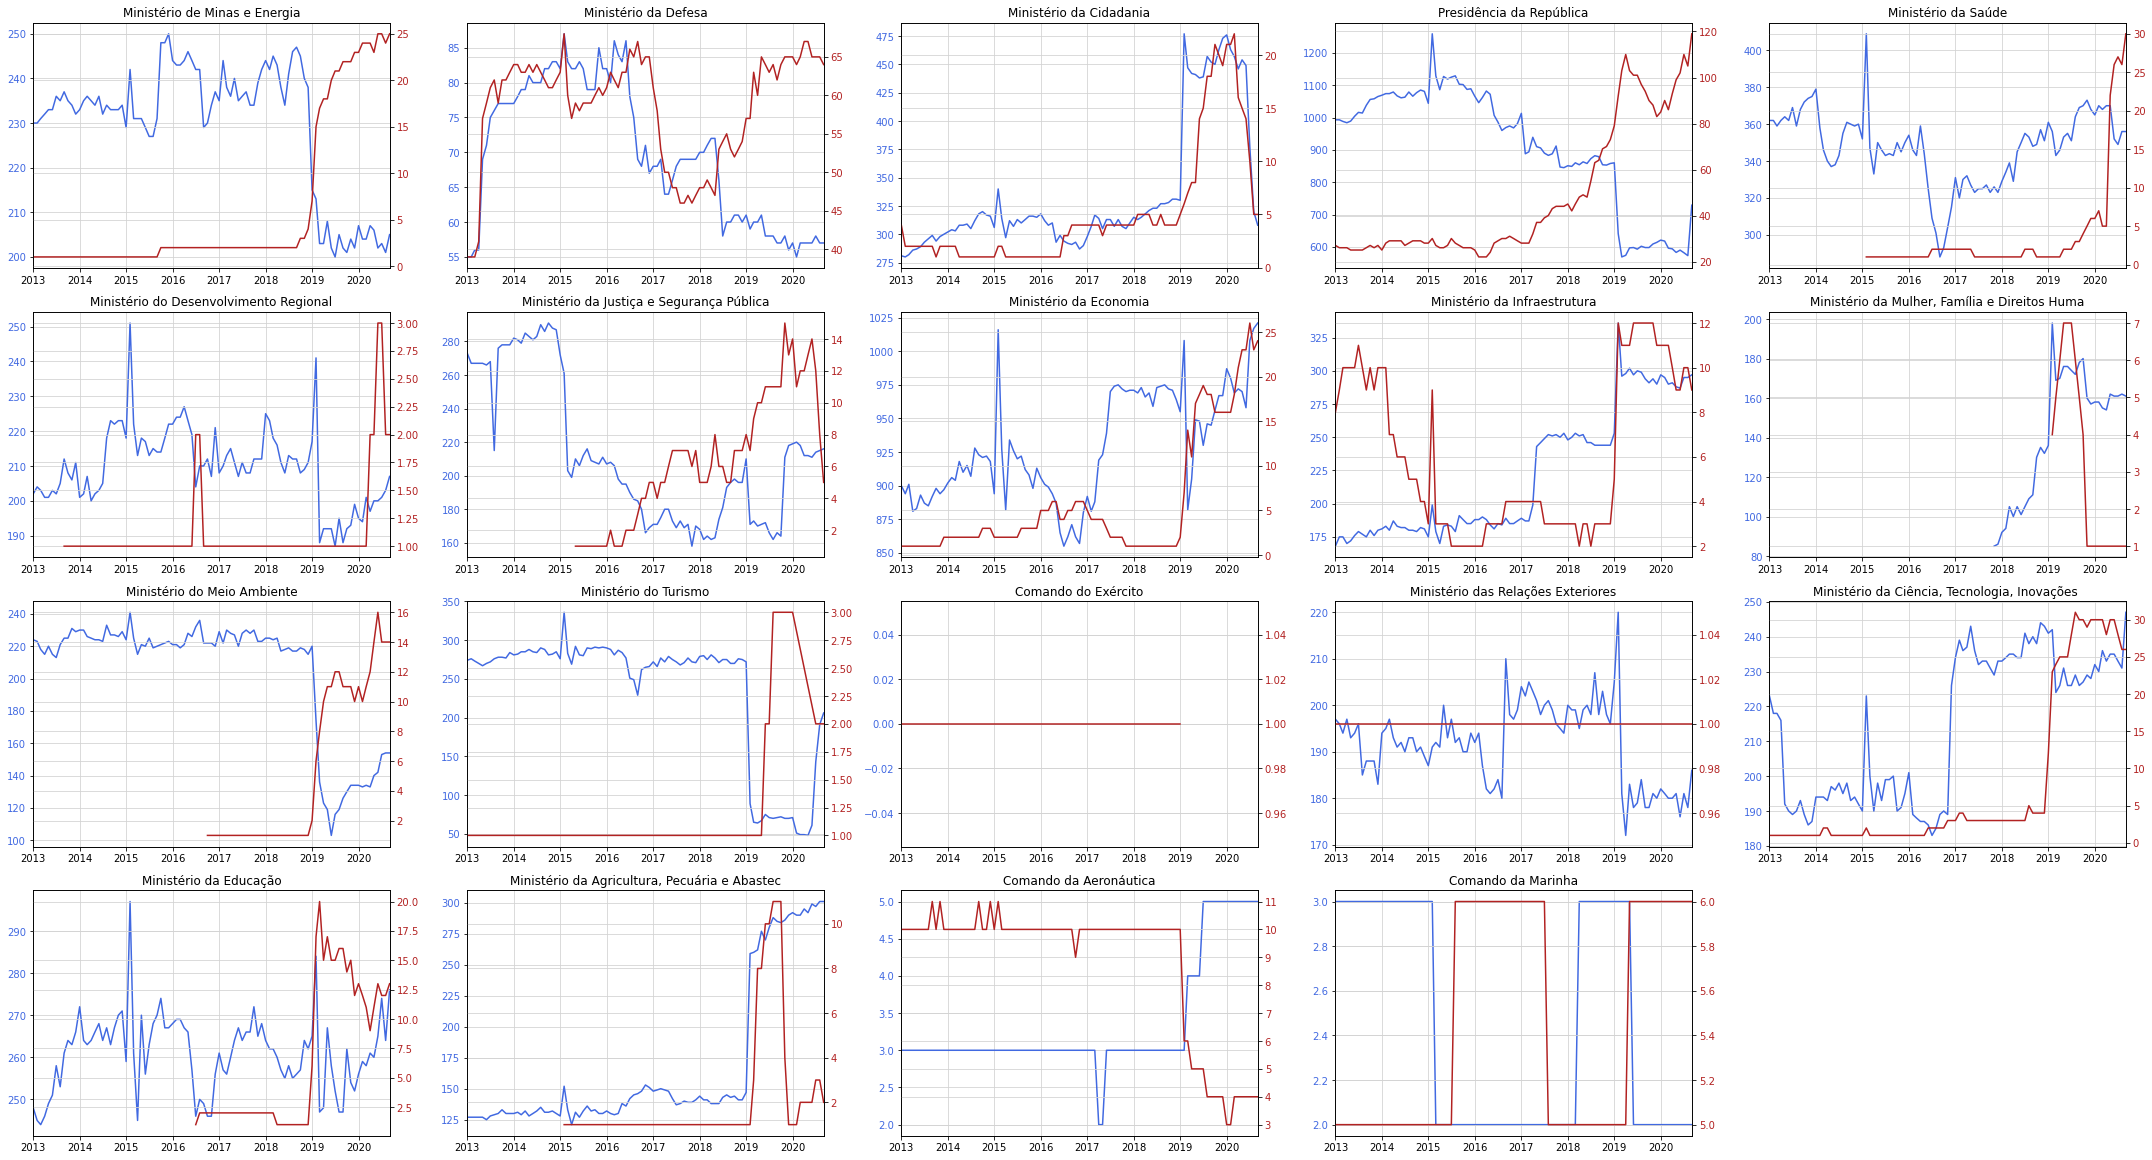

In [73]:
pl.figure(figsize=(30, 4 * 25/5))
for i, org in enumerate(orgsup_list):
    pl.subplot(5, 5, i + 1)
    pl.title(org)
    plot_compare_servidor_counts(sel_cargos_altos(df_confianca_so_civis), sel_cargos_altos(df_confianca_ativos_inativos), orgao=org)
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-09-01']))
pl.tight_layout()
pl.show()

### Gráficos de exploração - número de servidores militares e civis, da ativa e inativos, e em certos órgãos

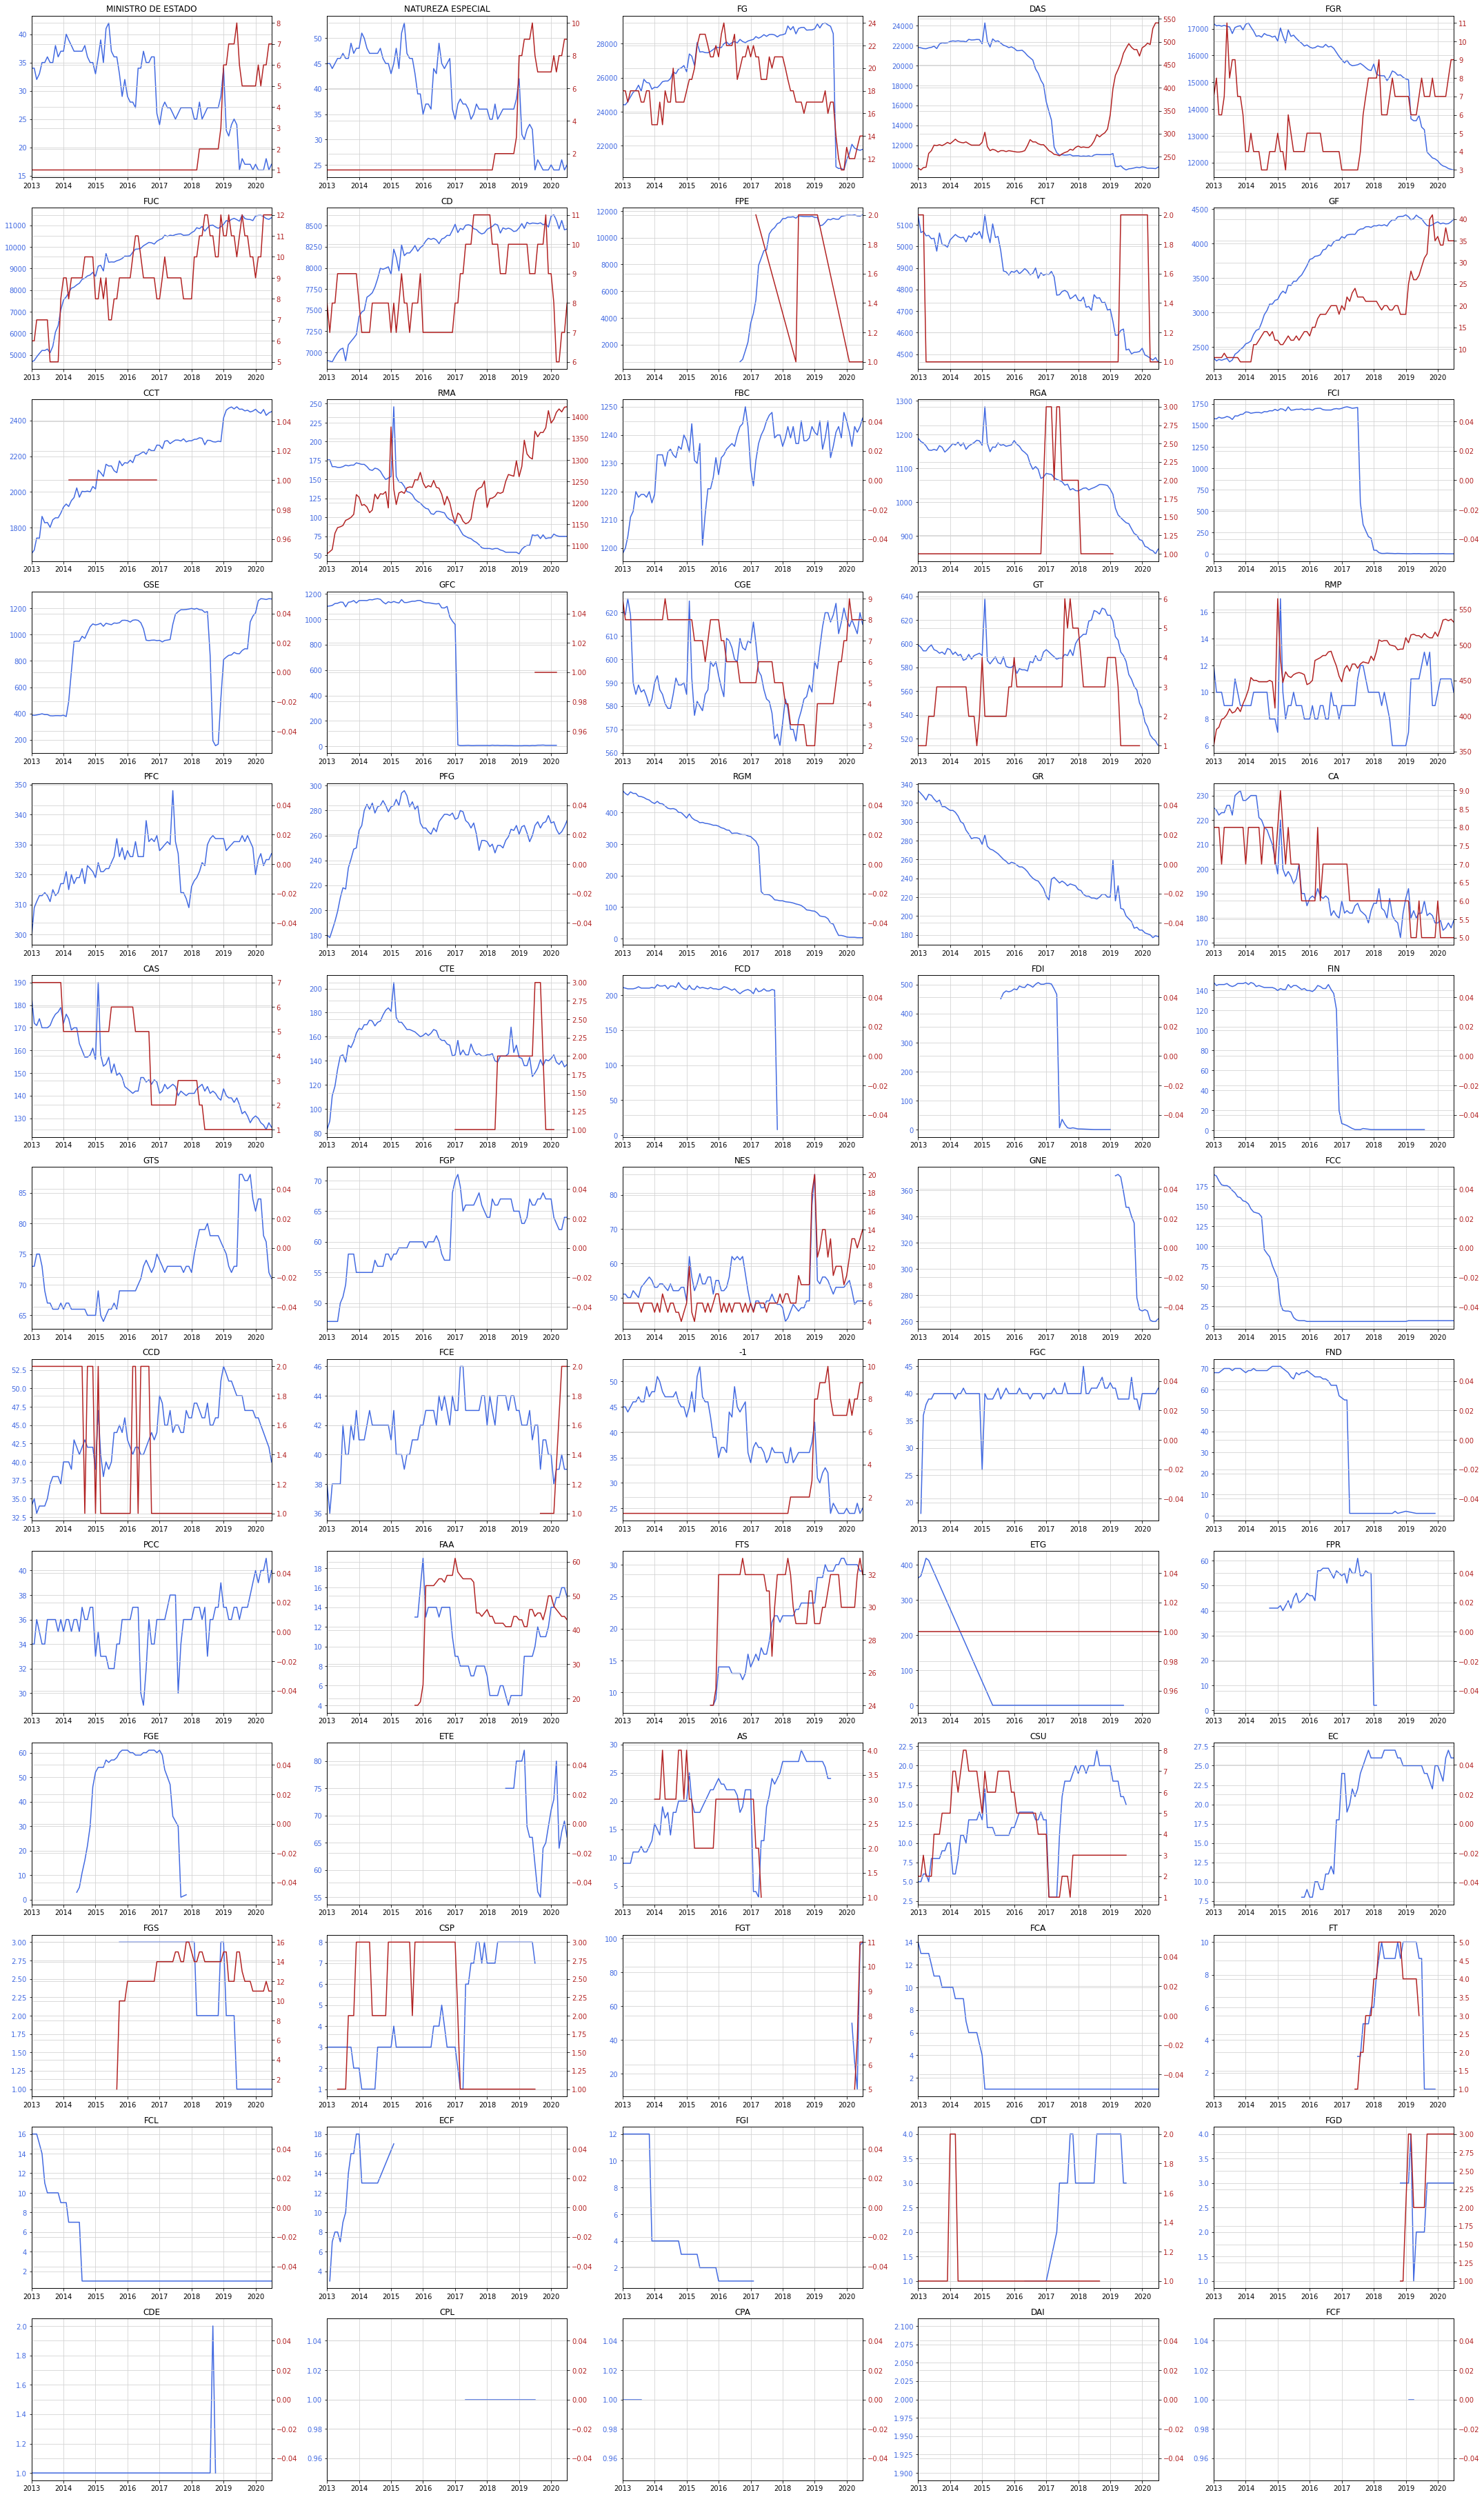

In [19]:
pl.figure(figsize=(30, 4 * 63/5))
for i, funcao in enumerate(funcao_list):
    pl.subplot(13, 5, i + 1)
    pl.title(funcao)
    plot_compare_servidor_counts(df_confianca_so_civis, df_confianca_ativos_inativos, funcao)
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))
pl.tight_layout()
pl.show()

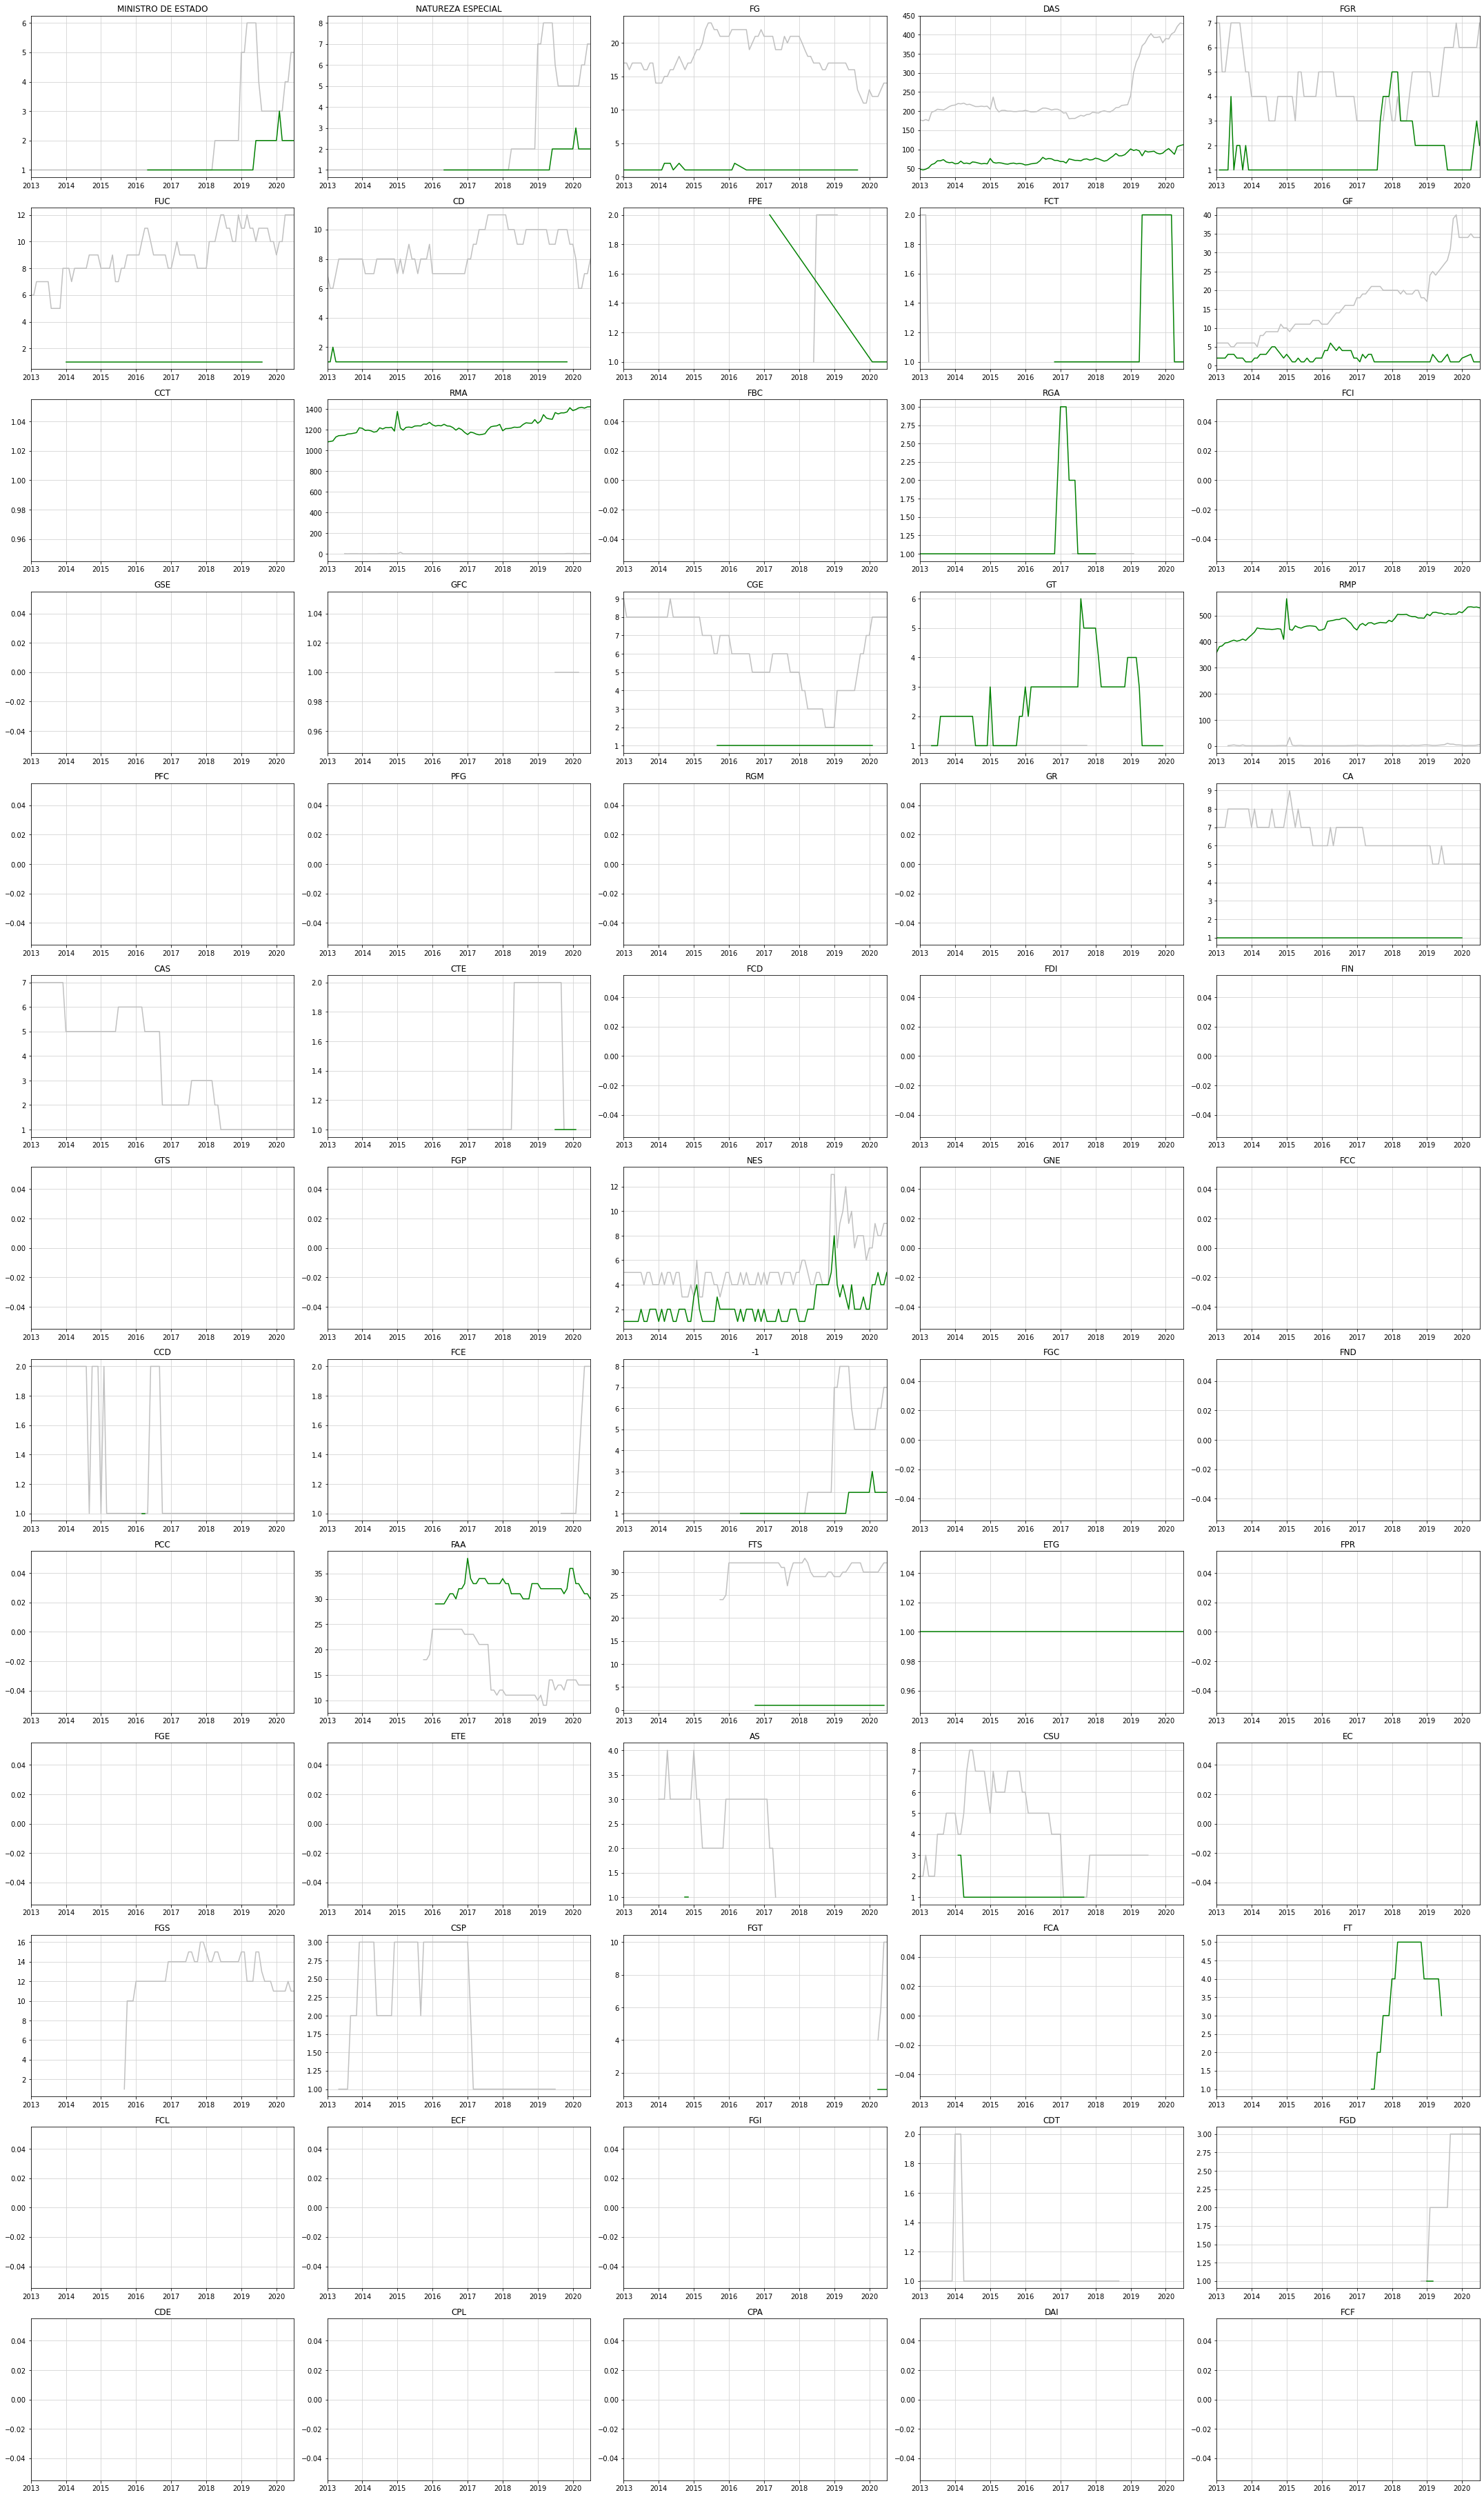

In [21]:
pl.figure(figsize=(30, 4 * 63/5))
for i, funcao in enumerate(funcao_list):
    pl.subplot(13, 5, i + 1)
    pl.title(funcao)
    #plot_compare_servidor_counts(df_confianca_inativos, df_confianca_militares, funcao)
    pl.plot(count_servidores_by_date(df_confianca_inativos, funcao), color='silver')
    pl.plot(count_servidores_by_date(df_confianca_militares, funcao), color='g')
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))
pl.tight_layout()
pl.show()

In [24]:
orgsup_list = all_confianca.loc[all_confianca['orgsup_exercicio'] != 'Sem informação', 'orgsup_exercicio'].unique()

In [122]:
all_confianca.loc[all_confianca.sigla_funcao == 'FCD'].sample(4).transpose()

2775765  \
mes                                                            2   
ano                                                         2015   
id_servidor                                              3410172   
nome                                   ROBERTO CORDEIRO DA SILVA   
cpf                                               ***.936.124-**   
desc_cargo                                        Sem informação   
classe_cargo                                                 NaN   
padrao_cargo                                                  -1   
nivel_cargo                                                   -1   
sigla_funcao                                                 FCD   
nivel_funcao                                                0001   
funcao                      FUNCAO COMISSIONADA DO DNPM - FCDNPM   
atividade                                                  CHEFE   
uorg_lotacao                     SUPERINTENDENCIA CLASSE I-B: BA   
org_lotacao            Departamento Nacional de Produção Mineral   
orgsup_lotacao                     Ministério de Minas e Energia   
uorg_exercicio                   SUPERINTENDENCIA CLASSE I-B: BA   
org_exercicio          Departamento Nacional de Produção Mineral   
orgsup_exercicio                   Ministério de Minas e Energia   
tipo_vinculo                                                   1   
situacao_vinculo                                ATIVO PERMANENTE   
regime_juridico                            REGIME JURIDICO UNICO   
jornada_de_trabalho                            40 HORAS SEMANAIS   
ingresso_cargo_funcao                                 19/03/2010   
ingresso_orgao                                        07/07/1995   
data                                         2015-02-01 00:00:00   
base                                                       civis   

                                                         3703134  \
mes                                                           12   
ano                                                         2016   
id_servidor                                               808655   
nome                                   FRANCISCA LIMA DE ALMEIDA   
cpf                                               ***.128.591-**   
desc_cargo                                        Sem informação   
classe_cargo                                                 NaN   
padrao_cargo                                                  -1   
nivel_cargo                                                   -1   
sigla_funcao                                                 FCD   
nivel_funcao                                                0004   
funcao                      FUNCAO COMISSIONADA DO DNPM - FCDNPM   
atividade                                          AUDITOR CHEFE   
uorg_lotacao                        CONTROLADORIA-GERAL DA UNIAO   
org_lotacao                         Controladoria-Geral da União   
orgsup_lotacao                          Presidência da República   
uorg_exercicio              COORDENAÇÃO 2 DE RECURSOS LOGÍSTICOS   
org_exercicio          Departamento Nacional de Produção Mineral   
orgsup_exercicio                   Ministério de Minas e Energia   
tipo_vinculo                                                   1   
situacao_vinculo                              CEDIDO/REQUISITADO   
regime_juridico                            REGIME JURIDICO UNICO   
jornada_de_trabalho                            40 HORAS SEMANAIS   
ingresso_cargo_funcao                                 15/10/2013   
ingresso_orgao                                        07/10/2013   
data                                         2016-12-01 00:00:00   
base                                                       civis   

                                                         5546091  \
mes                                                            2   
ano                                                         2014   
id_servidor                                

In [79]:
xu.unique(all_confianca['orgsup_exercicio'])

26: Comando da Aeronáutica | Comando da Marinha | Comando do Exército | Ministério da Agricultura, Pecuária e Abastec | Ministério da Ciência, Tecnologia, Inovações  | Ministério da Cultura | Ministério da Defesa | Ministério da Economia | Ministério da Educação | Ministério da Indústria, Comércio Exterior e  | Ministério da Infraestrutura | Ministério da Justiça e Segurança Pública | Ministério da Mulher, Família e Direitos Huma | Ministério da Saúde | Ministério das Cidades | Ministério das Relações Exteriores | Ministério de Minas e Energia | Ministério do Desenvolvimento Regional | Ministério do Desenvolvimento Social | Ministério do Esporte | Ministério do Meio Ambiente | Ministério do Planejamento, Desenvolvimento e | Ministério do Trabalho e Emprego | Ministério do Turismo | Presidência da República | Sem informação


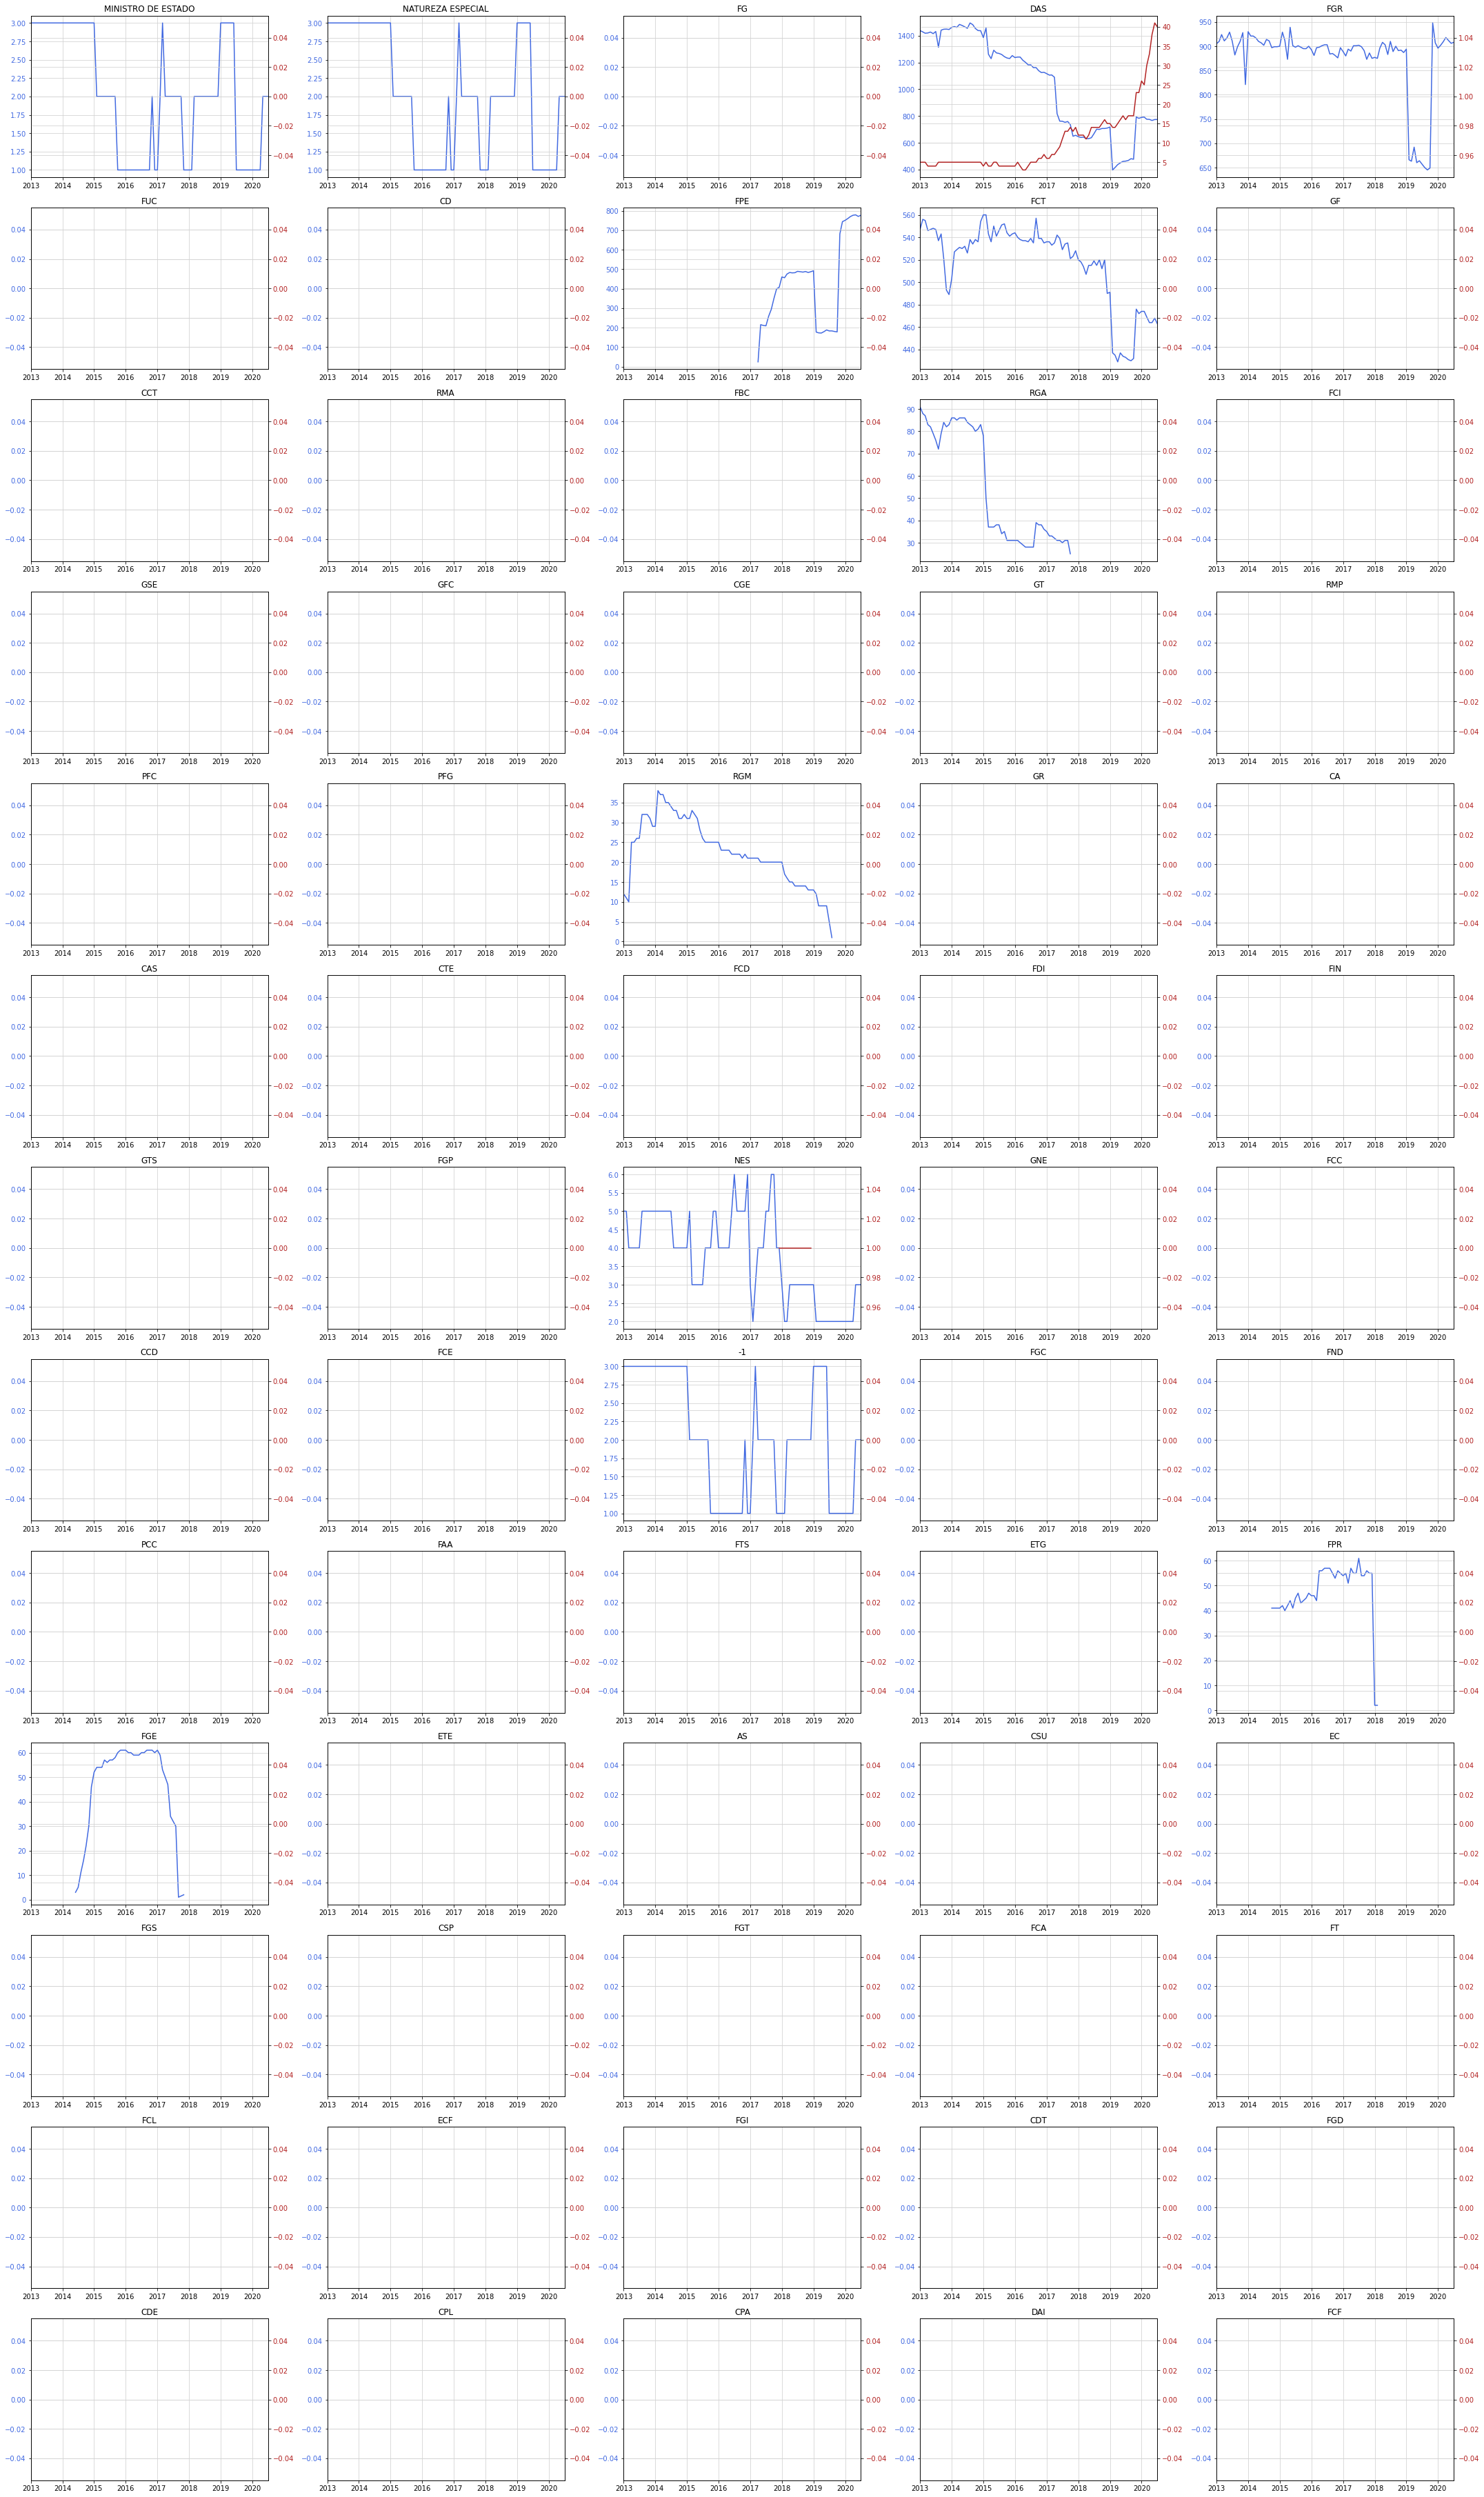

In [27]:
pl.figure(figsize=(30, 4 * 63/5))
for i, funcao in enumerate(funcao_list):
    pl.subplot(13, 5, i + 1)
    pl.title(funcao)
    plot_compare_servidor_counts(df_confianca_so_civis, df_confianca_ativos_inativos, funcao, 'Ministério da Justiça e Segurança Pública')
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))
pl.tight_layout()
pl.show()

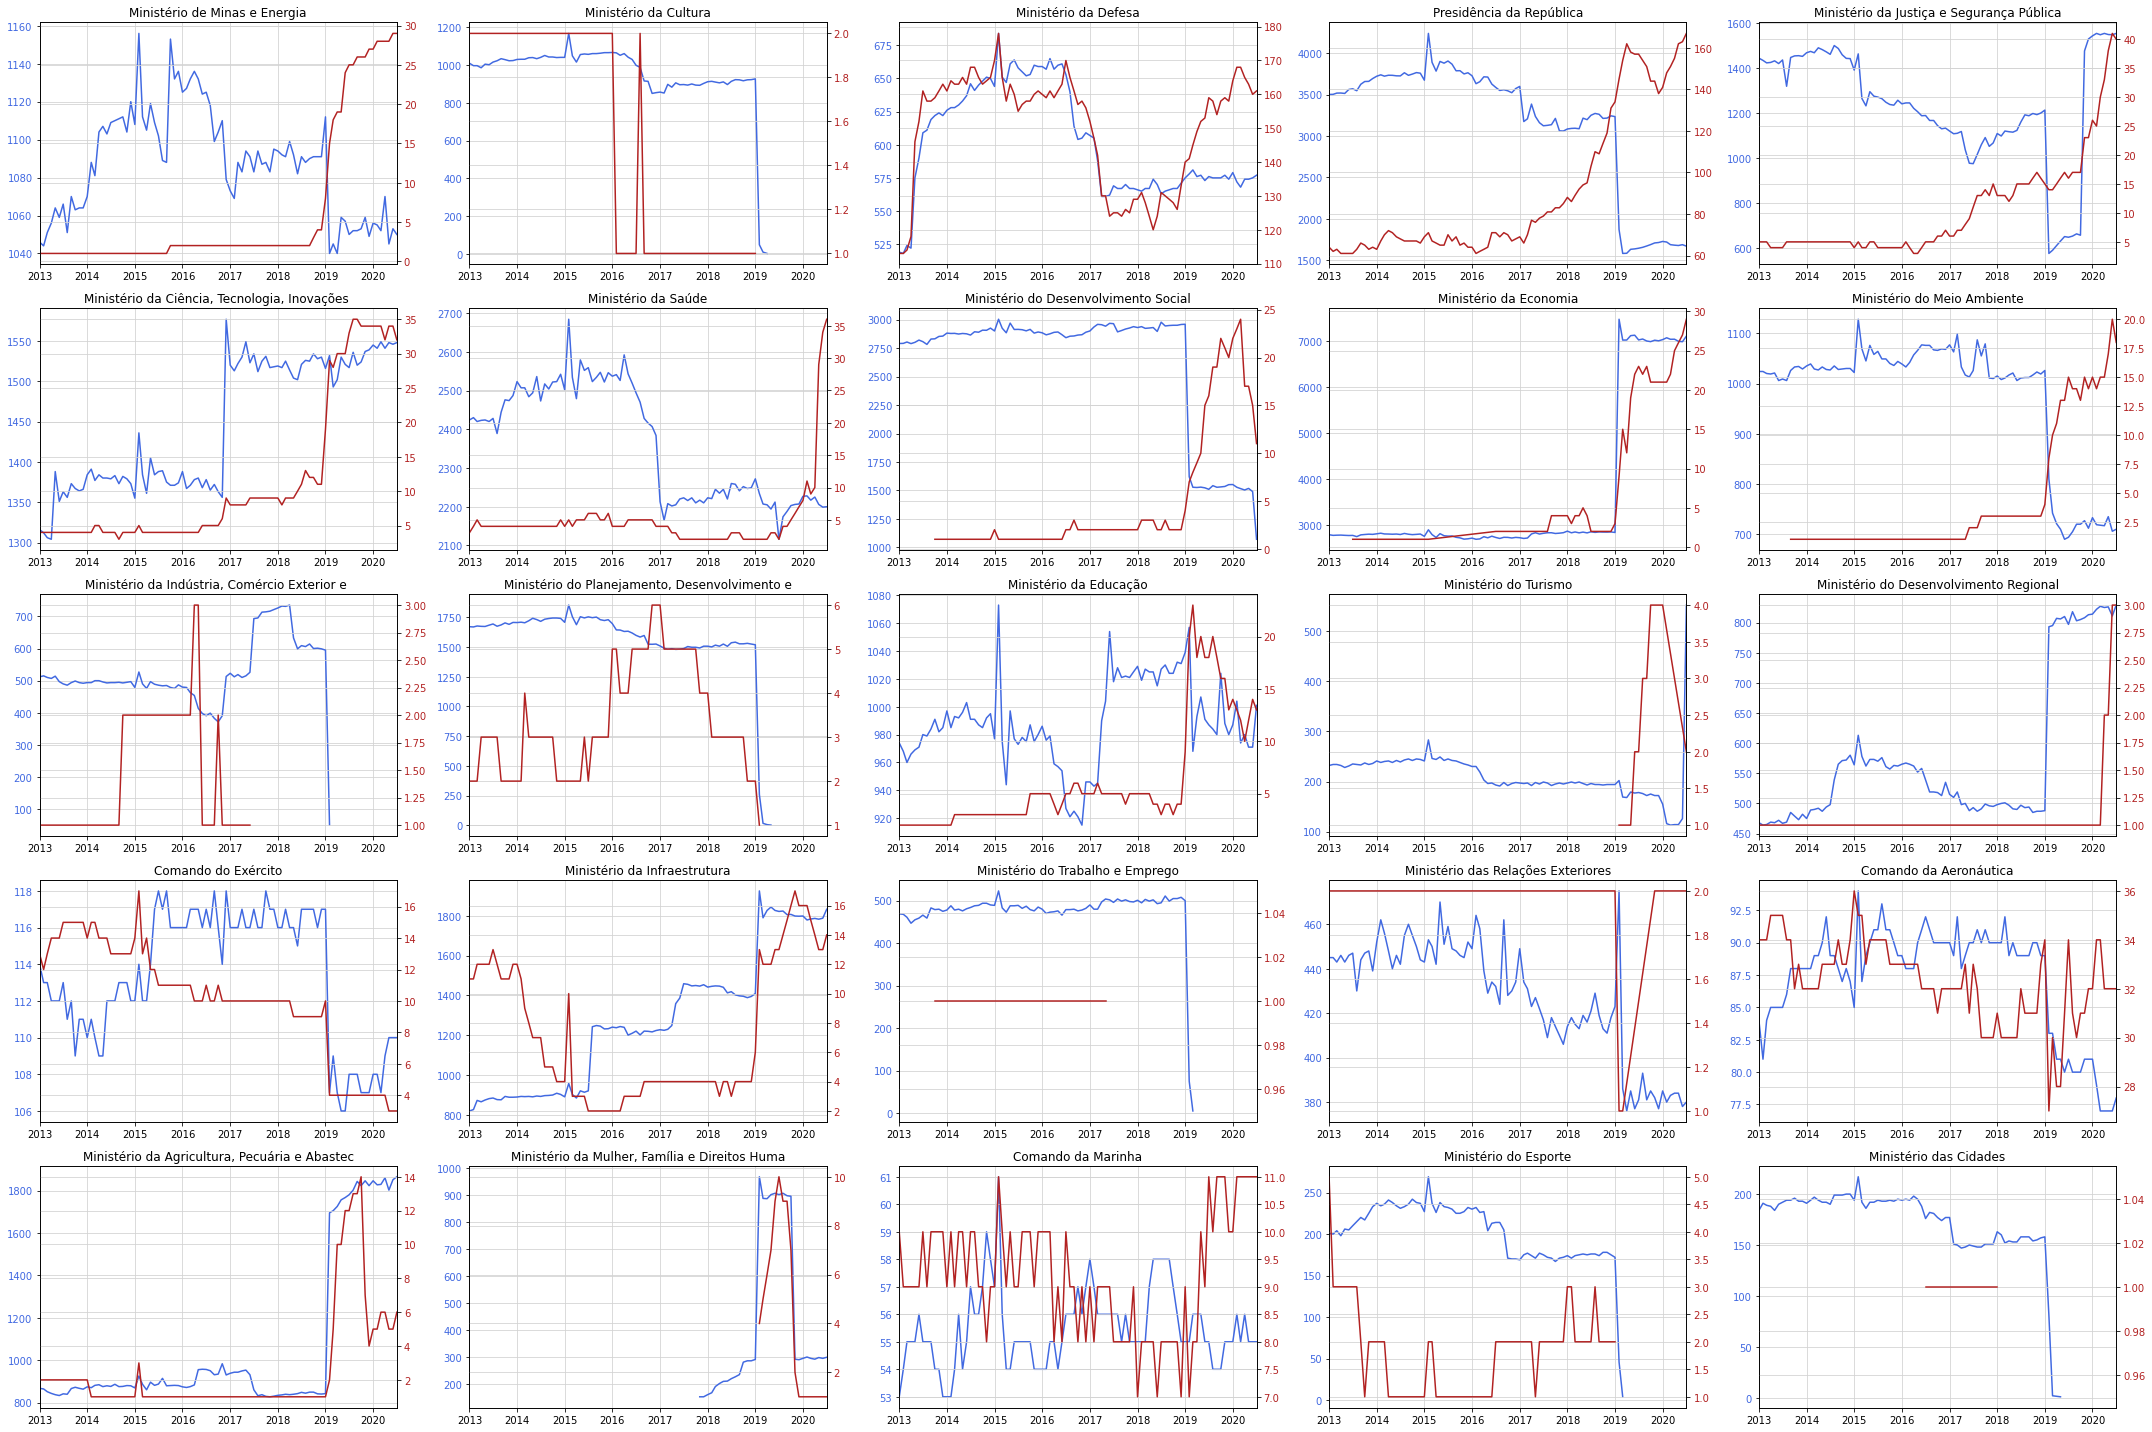

In [25]:
pl.figure(figsize=(30, 4 * 25/5))
for i, org in enumerate(orgsup_list):
    pl.subplot(5, 5, i + 1)
    pl.title(org)
    plot_compare_servidor_counts(df_confianca_so_civis, df_confianca_ativos_inativos, ['DAS', 'FPE', 'CGE', 'NES', 'FCI', 'FCD', 'FDI'], org)
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))
pl.tight_layout()
pl.show()

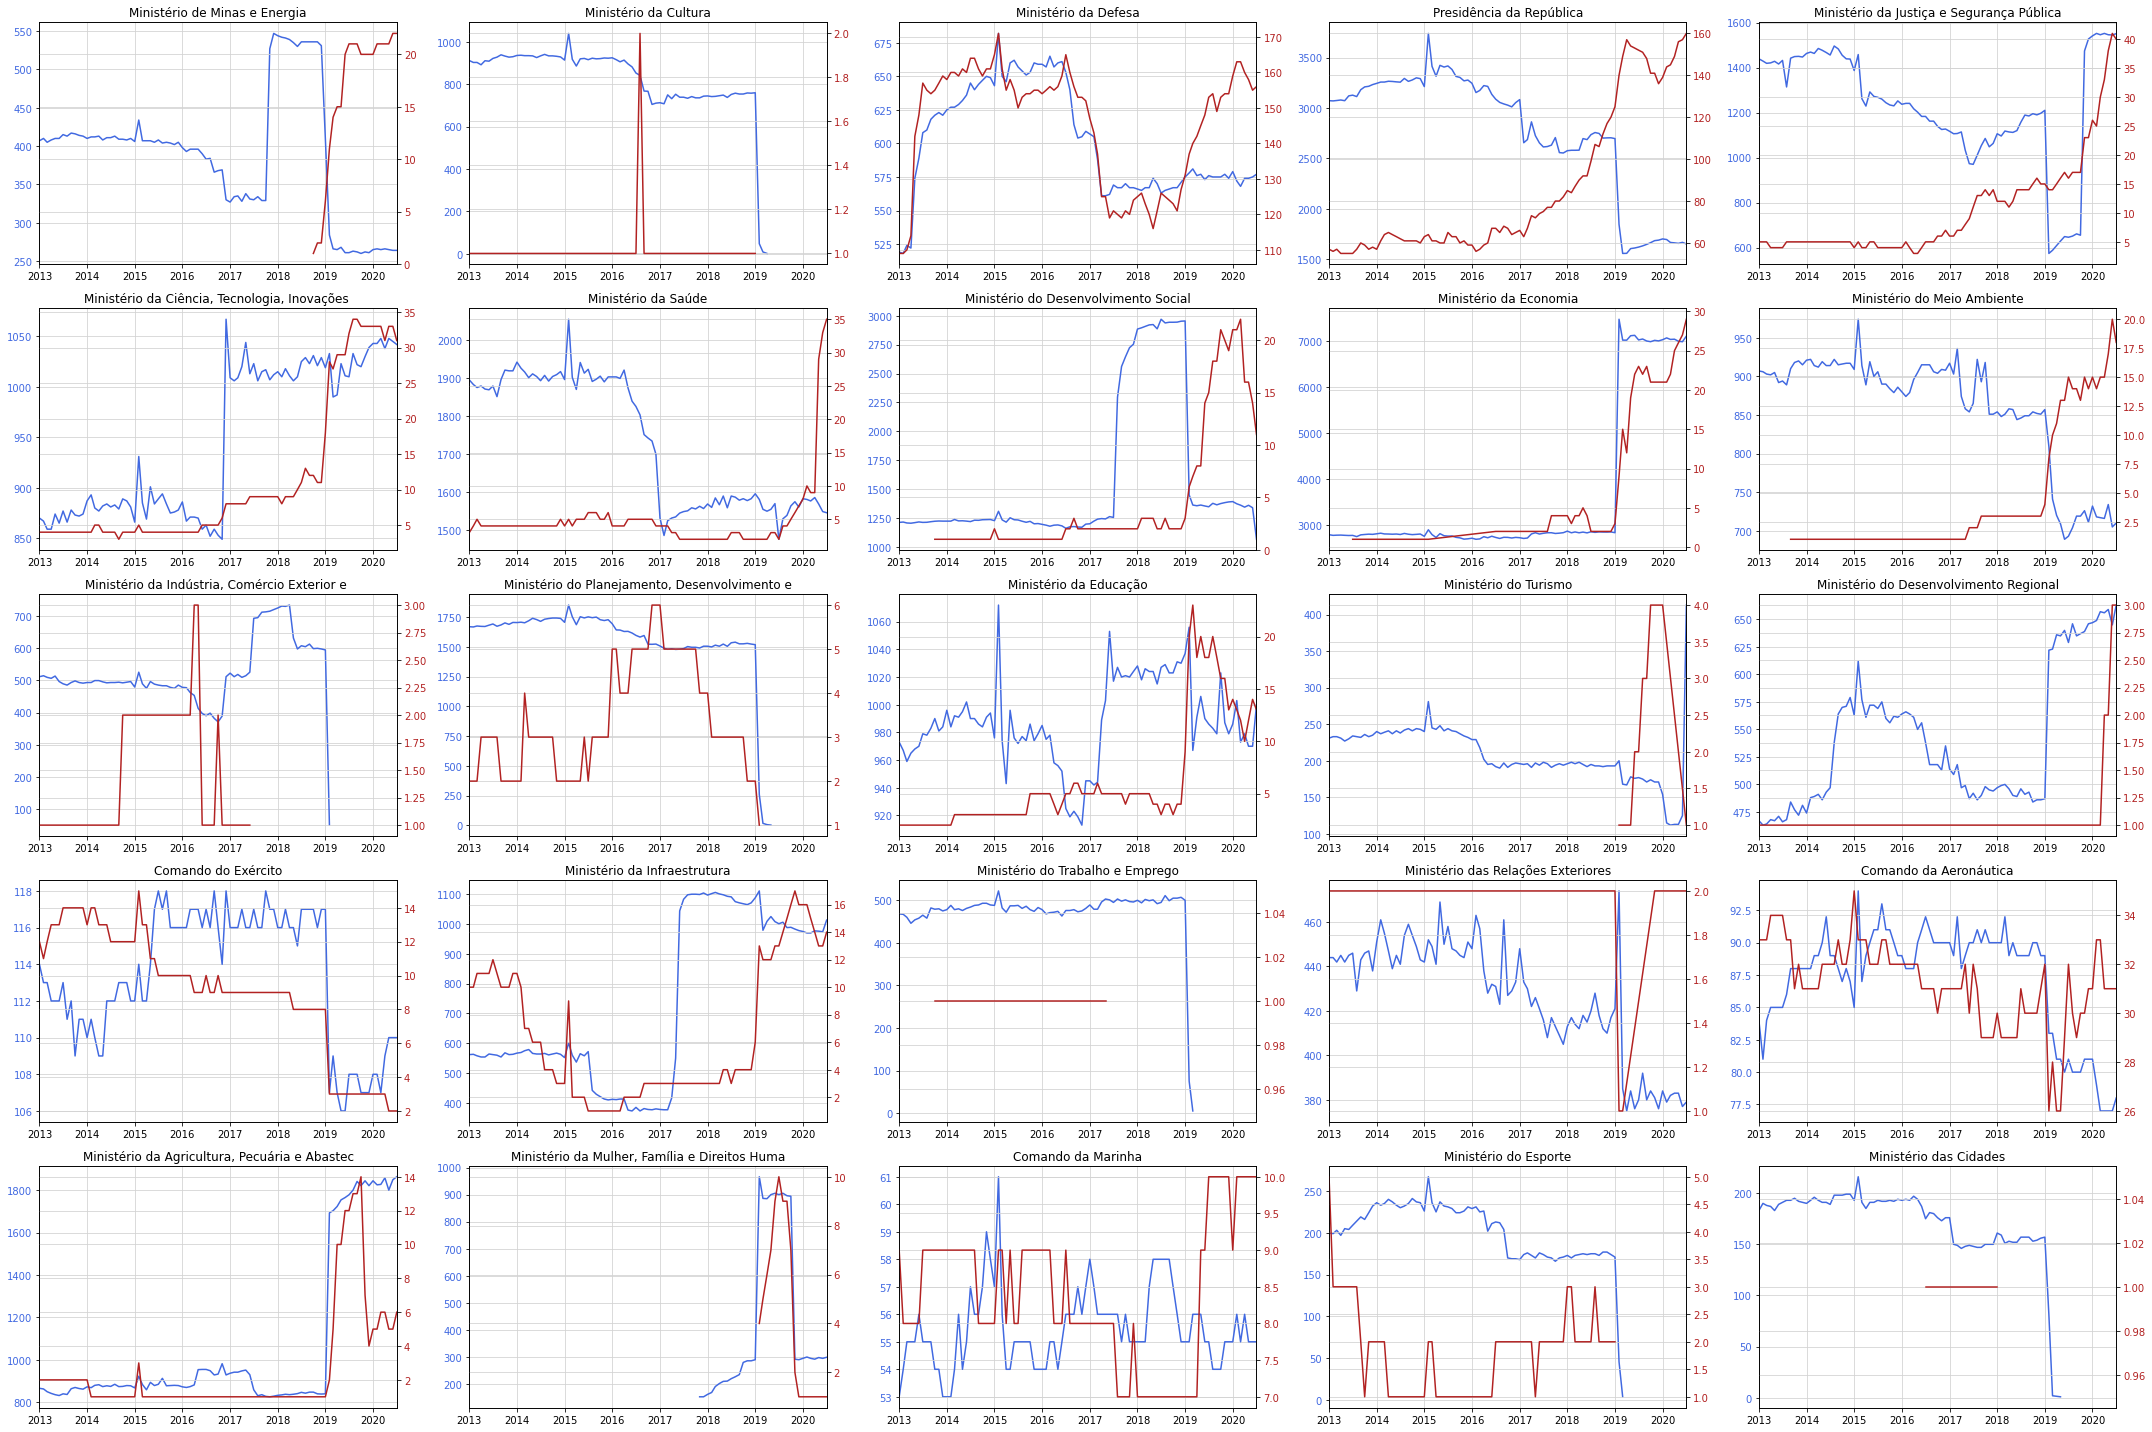

In [116]:
pl.figure(figsize=(30, 4 * 25/5))
for i, org in enumerate(orgsup_list):
    pl.subplot(5, 5, i + 1)
    pl.title(org)
    plot_compare_servidor_counts(df_confianca_so_civis, df_confianca_ativos_inativos, ['DAS', 'FPE'], org)
    pl.grid(color='lightgray')
    pl.xlim(pd.to_datetime(['2013-01-01', '2020-07-01']))
pl.tight_layout()
pl.show()